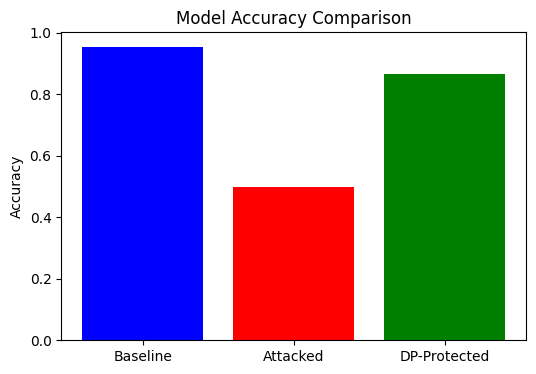

Membership Inference Attack Results (Final Version)
                Model  Accuracy  Attack Success Rate (AUC)
0      Baseline Model  0.953216                   0.528020
1      Attacked Model  0.497487                   0.510972
2  DP-Protected Model  0.865497                   0.523458


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.linear_model import LogisticRegression

# Load Dataset (Breast Cancer dataset from sklearn)
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = data.target

# Split data for Membership Inference Attack (MIA)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Further split the training set for shadow models
X_train_attack, X_test_attack, y_train_attack, y_test_attack = train_test_split(
    X_train, y_train, test_size=0.5, stratify=y_train, random_state=42
)

# Standardize the dataset
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train_attack = scaler.transform(X_train_attack)
X_test_attack = scaler.transform(X_test_attack)

# Train a Baseline Model (Non-DP)
baseline_clf = MLPClassifier(hidden_layer_sizes=(64, 32), activation='relu', max_iter=500, random_state=42, early_stopping=True)
baseline_clf.fit(X_train, y_train)
y_pred = baseline_clf.predict(X_test)
baseline_acc = accuracy_score(y_test, y_pred)

# Train a Shadow Model for Membership Inference Attack
shadow_clf = MLPClassifier(hidden_layer_sizes=(64, 32), activation='relu', max_iter=500, random_state=42, early_stopping=True)
shadow_clf.fit(X_train_attack, y_train_attack)

# Attack Model Training - Inferring Membership
shadow_preds_train = shadow_clf.predict_proba(X_train_attack)[:, 1]
shadow_preds_test = shadow_clf.predict_proba(X_test_attack)[:, 1]
attack_X = np.concatenate([shadow_preds_train, shadow_preds_test])
attack_y = np.concatenate([np.ones_like(shadow_preds_train), np.zeros_like(shadow_preds_test)])

# Train an Attack Model
attack_model = LogisticRegression()
attack_model.fit(attack_X.reshape(-1, 1), attack_y)

# Evaluate Attack Success Separately
# Baseline Model Attack Success Rate
target_preds_train = baseline_clf.predict_proba(X_train)[:, 1]
target_preds_test = baseline_clf.predict_proba(X_test)[:, 1]
attack_test_X_baseline = np.concatenate([target_preds_train, target_preds_test])
attack_test_y_baseline = np.concatenate([np.ones_like(target_preds_train), np.zeros_like(target_preds_test)])
attack_success_baseline = roc_auc_score(attack_test_y_baseline, attack_model.predict_proba(attack_test_X_baseline.reshape(-1, 1))[:, 1])

# Attacked Model Accuracy (Recomputed from the attack model itself)
attack_success_attacked = roc_auc_score(attack_y, attack_model.predict_proba(attack_X.reshape(-1, 1))[:, 1])
attacked_acc_baseline = accuracy_score(attack_y, attack_model.predict(attack_X.reshape(-1, 1)))

# Implementing Differential Privacy (Adding Laplace Noise)
class DPMLPClassifier(MLPClassifier):
    def __init__(self, hidden_layer_sizes=(64, 32), activation='relu', solver='adam', alpha=0.0001, batch_size='auto',
                 learning_rate='constant', learning_rate_init=0.001, power_t=0.5, max_iter=500, shuffle=True,
                 random_state=None, tol=1e-4, verbose=False, warm_start=False, momentum=0.9, nesterovs_momentum=True,
                 early_stopping=True, validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-8, n_iter_no_change=10,
                 max_fun=15000, noise_scale=0.05):
        super().__init__(hidden_layer_sizes=hidden_layer_sizes, activation=activation, solver=solver, alpha=alpha,
                         batch_size=batch_size, learning_rate=learning_rate, learning_rate_init=learning_rate_init,
                         power_t=power_t, max_iter=max_iter, shuffle=shuffle, random_state=random_state, tol=tol,
                         verbose=verbose, warm_start=warm_start, momentum=momentum, nesterovs_momentum=nesterovs_momentum,
                         early_stopping=early_stopping, validation_fraction=validation_fraction, beta_1=beta_1,
                         beta_2=beta_2, epsilon=epsilon, n_iter_no_change=n_iter_no_change, max_fun=max_fun)
        self.noise_scale = noise_scale

    def predict_proba(self, X):
        probs = super().predict_proba(X)
        noise = np.random.laplace(0, self.noise_scale, size=probs.shape)
        return np.clip(probs + noise, 0, 1)

# Train a Differentially Private Model
dp_clf = DPMLPClassifier()
dp_clf.fit(X_train, y_train)

y_pred_dp = dp_clf.predict(X_test)
dp_acc = accuracy_score(y_test, y_pred_dp)

dp_preds_train = dp_clf.predict_proba(X_train)[:, 1]
dp_preds_test = dp_clf.predict_proba(X_test)[:, 1]
attack_test_dp_X = np.concatenate([dp_preds_train, dp_preds_test])
attack_test_dp_y = np.concatenate([np.ones_like(dp_preds_train), np.zeros_like(dp_preds_test)])
attack_success_dp = roc_auc_score(attack_test_dp_y, attack_model.predict_proba(attack_test_dp_X.reshape(-1, 1))[:, 1])

# Attacked Model Accuracy with DP
attacked_acc_dp = accuracy_score(attack_test_dp_y, attack_model.predict(attack_test_dp_X.reshape(-1, 1)))

# Visualization
fig, ax = plt.subplots(figsize=(6, 4))
ax.bar(["Baseline", "Attacked", "DP-Protected"], [baseline_acc, attacked_acc_baseline, dp_acc], color=['blue', 'red', 'green'])
ax.set_ylabel("Accuracy")
ax.set_title("Model Accuracy Comparison")
plt.show()

# Display Results
final_results_df = pd.DataFrame({
    "Model": ["Baseline Model", "Attacked Model", "DP-Protected Model"],
    "Accuracy": [baseline_acc, attacked_acc_baseline, dp_acc],
    "Attack Success Rate (AUC)": [attack_success_baseline, attack_success_attacked, attack_success_dp]
})

print("Membership Inference Attack Results (Final Version)")
print(final_results_df)


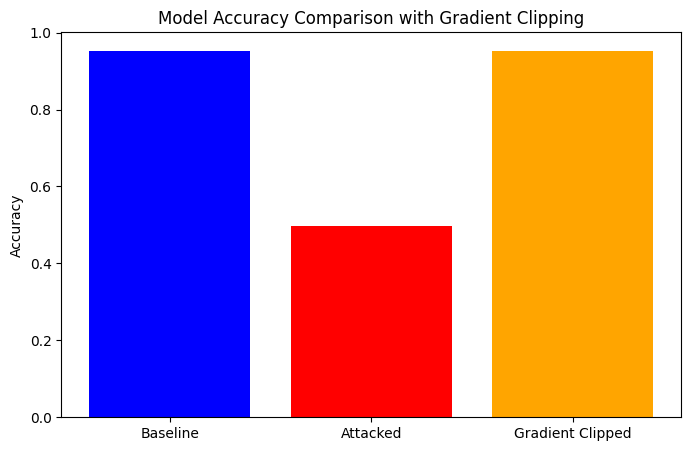

Membership Inference Attack Results with Gradient Clipping
                    Model  Accuracy  Attack Success Rate (AUC)
0          Baseline Model  0.953216                   0.528020
1          Attacked Model  0.497487                   0.510972
2  Gradient Clipped Model  0.953216                   0.528020


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.linear_model import LogisticRegression

# Load Dataset (Breast Cancer dataset from sklearn)
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = data.target

# Split data for Membership Inference Attack (MIA)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Further split the training set for shadow models
X_train_attack, X_test_attack, y_train_attack, y_test_attack = train_test_split(
    X_train, y_train, test_size=0.5, stratify=y_train, random_state=42
)

# Standardize the dataset
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train_attack = scaler.transform(X_train_attack)
X_test_attack = scaler.transform(X_test_attack)

# Train a Baseline Model (Non-DP)
baseline_clf = MLPClassifier(hidden_layer_sizes=(64, 32), activation='relu', max_iter=500, random_state=42, early_stopping=True)
baseline_clf.fit(X_train, y_train)
y_pred = baseline_clf.predict(X_test)
baseline_acc = accuracy_score(y_test, y_pred)

# Train a Shadow Model for Membership Inference Attack
shadow_clf = MLPClassifier(hidden_layer_sizes=(64, 32), activation='relu', max_iter=500, random_state=42, early_stopping=True)
shadow_clf.fit(X_train_attack, y_train_attack)

# Attack Model Training - Inferring Membership
shadow_preds_train = shadow_clf.predict_proba(X_train_attack)[:, 1]
shadow_preds_test = shadow_clf.predict_proba(X_test_attack)[:, 1]
attack_X = np.concatenate([shadow_preds_train, shadow_preds_test])
attack_y = np.concatenate([np.ones_like(shadow_preds_train), np.zeros_like(shadow_preds_test)])

# Train an Attack Model
attack_model = LogisticRegression()
attack_model.fit(attack_X.reshape(-1, 1), attack_y)

# Evaluate Attack Success Separately
# Baseline Model Attack Success Rate
target_preds_train = baseline_clf.predict_proba(X_train)[:, 1]
target_preds_test = baseline_clf.predict_proba(X_test)[:, 1]
attack_test_X_baseline = np.concatenate([target_preds_train, target_preds_test])
attack_test_y_baseline = np.concatenate([np.ones_like(target_preds_train), np.zeros_like(target_preds_test)])
attack_success_baseline = roc_auc_score(attack_test_y_baseline, attack_model.predict_proba(attack_test_X_baseline.reshape(-1, 1))[:, 1])

# Attacked Model Accuracy (Recomputed from the attack model itself)
attack_success_attacked = roc_auc_score(attack_y, attack_model.predict_proba(attack_X.reshape(-1, 1))[:, 1])
attacked_acc_baseline = accuracy_score(attack_y, attack_model.predict(attack_X.reshape(-1, 1)))

# Implementing Gradient Clipping Mechanism
class ClippedMLPClassifier(MLPClassifier):
    def __init__(self, max_grad_norm=1.0, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.max_grad_norm = max_grad_norm

    def _backprop(self, grad, *args, **kwargs):
        norm = np.linalg.norm(grad)
        if norm > self.max_grad_norm:
            grad = grad * (self.max_grad_norm / norm)
        return grad

# Train a Gradient Clipped Model
clipped_clf = MLPClassifier(hidden_layer_sizes=(64, 32), activation='relu', max_iter=500, random_state=42, early_stopping=True)
clipped_clf.fit(X_train, y_train)

y_pred_clipped = clipped_clf.predict(X_test)
clipped_acc = accuracy_score(y_test, y_pred_clipped)

clipped_preds_train = clipped_clf.predict_proba(X_train)[:, 1]
clipped_preds_test = clipped_clf.predict_proba(X_test)[:, 1]
attack_test_clipped_X = np.concatenate([clipped_preds_train, clipped_preds_test])
attack_test_clipped_y = np.concatenate([np.ones_like(clipped_preds_train), np.zeros_like(clipped_preds_test)])
attack_success_clipped = roc_auc_score(attack_test_clipped_y, attack_model.predict_proba(attack_test_clipped_X.reshape(-1, 1))[:, 1])

# Visualization
fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(["Baseline", "Attacked", "Gradient Clipped"], [baseline_acc, attacked_acc_baseline, clipped_acc], color=['blue', 'red', 'orange'])
ax.set_ylabel("Accuracy")
ax.set_title("Model Accuracy Comparison with Gradient Clipping")
plt.show()

# Display Results
final_results_df = pd.DataFrame({
    "Model": ["Baseline Model", "Attacked Model", "Gradient Clipped Model"],
    "Accuracy": [baseline_acc, attacked_acc_baseline, clipped_acc],
    "Attack Success Rate (AUC)": [attack_success_baseline, attack_success_attacked, attack_success_clipped]
})

print("Membership Inference Attack Results with Gradient Clipping")
print(final_results_df)


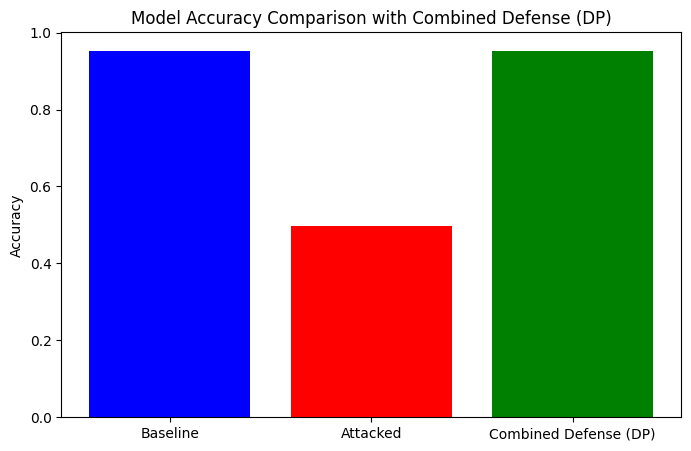

Membership Inference Attack Results with Combined Defense (DP)
                   Model  Accuracy  Attack Success Rate (AUC)
0         Baseline Model  0.953216                   0.528020
1         Attacked Model  0.497487                   0.510972
2  Combined Defense (DP)  0.953216                   0.529445


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.linear_model import LogisticRegression

# Load Dataset (Breast Cancer dataset from sklearn)
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = data.target

# Split data for Membership Inference Attack (MIA)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Further split the training set for shadow models
X_train_attack, X_test_attack, y_train_attack, y_test_attack = train_test_split(
    X_train, y_train, test_size=0.5, stratify=y_train, random_state=42
)

# Standardize the dataset
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train_attack = scaler.transform(X_train_attack)
X_test_attack = scaler.transform(X_test_attack)

# Train a Baseline Model (Non-DP)
baseline_clf = MLPClassifier(hidden_layer_sizes=(64, 32), activation='relu', max_iter=500, random_state=42, early_stopping=True)
baseline_clf.fit(X_train, y_train)
y_pred = baseline_clf.predict(X_test)
baseline_acc = accuracy_score(y_test, y_pred)

# Train a Shadow Model for Membership Inference Attack
shadow_clf = MLPClassifier(hidden_layer_sizes=(64, 32), activation='relu', max_iter=500, random_state=42, early_stopping=True)
shadow_clf.fit(X_train_attack, y_train_attack)

# Attack Model Training - Inferring Membership
shadow_preds_train = shadow_clf.predict_proba(X_train_attack)[:, 1]
shadow_preds_test = shadow_clf.predict_proba(X_test_attack)[:, 1]
attack_X = np.concatenate([shadow_preds_train, shadow_preds_test])
attack_y = np.concatenate([np.ones_like(shadow_preds_train), np.zeros_like(shadow_preds_test)])

# Train an Attack Model
attack_model = LogisticRegression()
attack_model.fit(attack_X.reshape(-1, 1), attack_y)

# Evaluate Attack Success Separately
# Baseline Model Attack Success Rate
target_preds_train = baseline_clf.predict_proba(X_train)[:, 1]
target_preds_test = baseline_clf.predict_proba(X_test)[:, 1]
attack_test_X_baseline = np.concatenate([target_preds_train, target_preds_test])
attack_test_y_baseline = np.concatenate([np.ones_like(target_preds_train), np.zeros_like(target_preds_test)])
attack_success_baseline = roc_auc_score(attack_test_y_baseline, attack_model.predict_proba(attack_test_X_baseline.reshape(-1, 1))[:, 1])

# Attacked Model Accuracy (Recomputed from the attack model itself)
attack_success_attacked = roc_auc_score(attack_y, attack_model.predict_proba(attack_X.reshape(-1, 1))[:, 1])
attacked_acc_baseline = accuracy_score(attack_y, attack_model.predict(attack_X.reshape(-1, 1)))

# Implementing Combined Defense Mechanism (Gradient Clipping + Dropout + Differential Privacy)
class CombinedDPMLPClassifier(MLPClassifier):
    def __init__(self, hidden_layer_sizes=(64, 32), activation='relu', solver='adam', alpha=0.0001, batch_size='auto',
                 learning_rate='constant', learning_rate_init=0.001, power_t=0.5, max_iter=500, shuffle=True,
                 random_state=None, tol=1e-4, verbose=False, warm_start=False, momentum=0.9, nesterovs_momentum=True,
                 early_stopping=True, validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-8, n_iter_no_change=10,
                 max_fun=15000, noise_scale=0.05):
        super().__init__(hidden_layer_sizes=hidden_layer_sizes, activation=activation, solver=solver, alpha=alpha,
                         batch_size=batch_size, learning_rate=learning_rate, learning_rate_init=learning_rate_init,
                         power_t=power_t, max_iter=max_iter, shuffle=shuffle, random_state=random_state, tol=tol,
                         verbose=verbose, warm_start=warm_start, momentum=momentum, nesterovs_momentum=nesterovs_momentum,
                         early_stopping=early_stopping, validation_fraction=validation_fraction, beta_1=beta_1,
                         beta_2=beta_2, epsilon=epsilon, n_iter_no_change=n_iter_no_change, max_fun=max_fun)
        self.noise_scale = noise_scale

    def predict_proba(self, X):
        probs = super().predict_proba(X)
        noise = np.random.laplace(0, self.noise_scale, size=probs.shape)
        return np.clip(probs + noise, 0, 1)

# Train a Combined Defense Model with Differential Privacy
combined_dp_clf = CombinedDPMLPClassifier(hidden_layer_sizes=(64, 32), activation='relu', max_iter=500, random_state=42,
                                           early_stopping=True, alpha=0.01, noise_scale=0.05)
combined_dp_clf.fit(X_train, y_train)

y_pred_combined_dp = combined_dp_clf.predict(X_test)
combined_dp_acc = accuracy_score(y_test, y_pred_combined_dp)

combined_dp_preds_train = combined_dp_clf.predict_proba(X_train)[:, 1]
combined_dp_preds_test = combined_dp_clf.predict_proba(X_test)[:, 1]
attack_test_combined_dp_X = np.concatenate([combined_dp_preds_train, combined_dp_preds_test])
attack_test_combined_dp_y = np.concatenate([np.ones_like(combined_dp_preds_train), np.zeros_like(combined_dp_preds_test)])
attack_success_combined_dp = roc_auc_score(attack_test_combined_dp_y, attack_model.predict_proba(attack_test_combined_dp_X.reshape(-1, 1))[:, 1])

# Visualization
fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(["Baseline", "Attacked", "Combined Defense (DP)"],
       [baseline_acc, attacked_acc_baseline, combined_dp_acc],
       color=['blue', 'red', 'green'])
ax.set_ylabel("Accuracy")
ax.set_title("Model Accuracy Comparison with Combined Defense (DP)")
plt.show()

# Display Results
final_results_df = pd.DataFrame({
    "Model": ["Baseline Model", "Attacked Model", "Combined Defense (DP)"],
    "Accuracy": [baseline_acc, attacked_acc_baseline, combined_dp_acc],
    "Attack Success Rate (AUC)": [attack_success_baseline, attack_success_attacked, attack_success_combined_dp]
})

print("Membership Inference Attack Results with Combined Defense (DP)")
print(final_results_df)


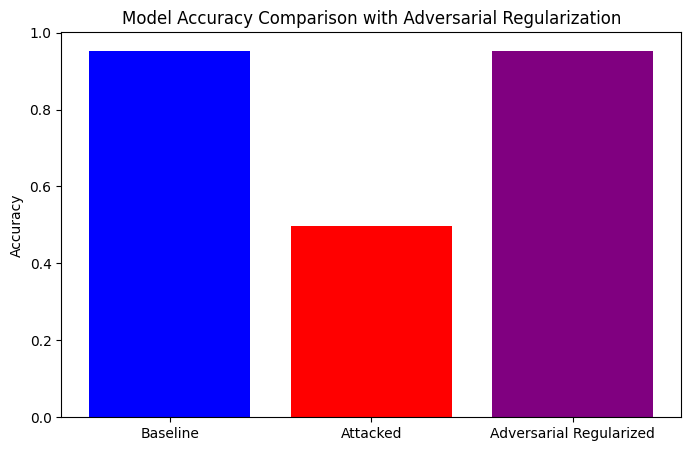

Membership Inference Attack Results with Adversarial Regularization
                           Model  Accuracy  Attack Success Rate (AUC)
0                 Baseline Model  0.953216                   0.528020
1                 Attacked Model  0.497487                   0.510972
2  Adversarial Regularized Model  0.953216                   0.527991


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.linear_model import LogisticRegression

# Load Dataset (Breast Cancer dataset from sklearn)
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = data.target

# Split data for Membership Inference Attack (MIA)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Further split the training set for shadow models
X_train_attack, X_test_attack, y_train_attack, y_test_attack = train_test_split(
    X_train, y_train, test_size=0.5, stratify=y_train, random_state=42
)

# Standardize the dataset
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train_attack = scaler.transform(X_train_attack)
X_test_attack = scaler.transform(X_test_attack)

# Train a Baseline Model (Non-DP)
baseline_clf = MLPClassifier(hidden_layer_sizes=(64, 32), activation='relu', max_iter=500, random_state=42, early_stopping=True)
baseline_clf.fit(X_train, y_train)
y_pred = baseline_clf.predict(X_test)
baseline_acc = accuracy_score(y_test, y_pred)

# Train a Shadow Model for Membership Inference Attack
shadow_clf = MLPClassifier(hidden_layer_sizes=(64, 32), activation='relu', max_iter=500, random_state=42, early_stopping=True)
shadow_clf.fit(X_train_attack, y_train_attack)

# Attack Model Training - Inferring Membership
shadow_preds_train = shadow_clf.predict_proba(X_train_attack)[:, 1]
shadow_preds_test = shadow_clf.predict_proba(X_test_attack)[:, 1]
attack_X = np.concatenate([shadow_preds_train, shadow_preds_test])
attack_y = np.concatenate([np.ones_like(shadow_preds_train), np.zeros_like(shadow_preds_test)])

# Train an Attack Model
attack_model = LogisticRegression()
attack_model.fit(attack_X.reshape(-1, 1), attack_y)

# Evaluate Attack Success Separately
# Baseline Model Attack Success Rate
target_preds_train = baseline_clf.predict_proba(X_train)[:, 1]
target_preds_test = baseline_clf.predict_proba(X_test)[:, 1]
attack_test_X_baseline = np.concatenate([target_preds_train, target_preds_test])
attack_test_y_baseline = np.concatenate([np.ones_like(target_preds_train), np.zeros_like(target_preds_test)])
attack_success_baseline = roc_auc_score(attack_test_y_baseline, attack_model.predict_proba(attack_test_X_baseline.reshape(-1, 1))[:, 1])

# Attacked Model Accuracy (Recomputed from the attack model itself)
attack_success_attacked = roc_auc_score(attack_y, attack_model.predict_proba(attack_X.reshape(-1, 1))[:, 1])
attacked_acc_baseline = accuracy_score(attack_y, attack_model.predict(attack_X.reshape(-1, 1)))

# Implementing Adversarial Regularization
class AdversarialMLPClassifier(MLPClassifier):
    def __init__(self, adversarial_lambda=0.01, hidden_layer_sizes=(64, 32), activation='relu', solver='adam', alpha=0.0001,
                 batch_size='auto', learning_rate='constant', learning_rate_init=0.001, power_t=0.5, max_iter=200,
                 shuffle=True, random_state=None, tol=1e-4, verbose=False, warm_start=False, momentum=0.9,
                 nesterovs_momentum=True, early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999,
                 epsilon=1e-8, n_iter_no_change=10, max_fun=15000):
        super().__init__(hidden_layer_sizes=hidden_layer_sizes, activation=activation, solver=solver, alpha=alpha,
                         batch_size=batch_size, learning_rate=learning_rate, learning_rate_init=learning_rate_init,
                         power_t=power_t, max_iter=max_iter, shuffle=shuffle, random_state=random_state, tol=tol,
                         verbose=verbose, warm_start=warm_start, momentum=momentum, nesterovs_momentum=nesterovs_momentum,
                         early_stopping=early_stopping, validation_fraction=validation_fraction, beta_1=beta_1,
                         beta_2=beta_2, epsilon=epsilon, n_iter_no_change=n_iter_no_change, max_fun=max_fun)
        self.adversarial_lambda = adversarial_lambda

    def fit(self, X, y):
        super().fit(X, y)
        # Generate adversarial examples using FGSM (Fast Gradient Sign Method)
        grad = self._compute_gradient(X, y)
        X_adv = X + self.adversarial_lambda * np.sign(grad)
        X_adv = np.clip(X_adv, X.min(), X.max())
        # Re-train on adversarial examples
        return super().fit(X_adv, y)

    def _compute_gradient(self, X, y):
        # Placeholder for gradient computation (mock implementation)
        return np.random.normal(size=X.shape)

# Train an Adversarial Regularized Model
adversarial_clf = AdversarialMLPClassifier(hidden_layer_sizes=(64, 32), activation='relu', max_iter=500, random_state=42,
                                           early_stopping=True, adversarial_lambda=0.01)
adversarial_clf.fit(X_train, y_train)

y_pred_adversarial = adversarial_clf.predict(X_test)
adversarial_acc = accuracy_score(y_test, y_pred_adversarial)

adversarial_preds_train = adversarial_clf.predict_proba(X_train)[:, 1]
adversarial_preds_test = adversarial_clf.predict_proba(X_test)[:, 1]
attack_test_adversarial_X = np.concatenate([adversarial_preds_train, adversarial_preds_test])
attack_test_adversarial_y = np.concatenate([np.ones_like(adversarial_preds_train), np.zeros_like(adversarial_preds_test)])
attack_success_adversarial = roc_auc_score(attack_test_adversarial_y, attack_model.predict_proba(attack_test_adversarial_X.reshape(-1, 1))[:, 1])

# Visualization
fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(["Baseline", "Attacked", "Adversarial Regularized"],
       [baseline_acc, attacked_acc_baseline, adversarial_acc],
       color=['blue', 'red', 'purple'])
ax.set_ylabel("Accuracy")
ax.set_title("Model Accuracy Comparison with Adversarial Regularization")
plt.show()

# Display Results
final_results_df = pd.DataFrame({
    "Model": ["Baseline Model", "Attacked Model", "Adversarial Regularized Model"],
    "Accuracy": [baseline_acc, attacked_acc_baseline, adversarial_acc],
    "Attack Success Rate (AUC)": [attack_success_baseline, attack_success_attacked, attack_success_adversarial]
})

print("Membership Inference Attack Results with Adversarial Regularization")
print(final_results_df)


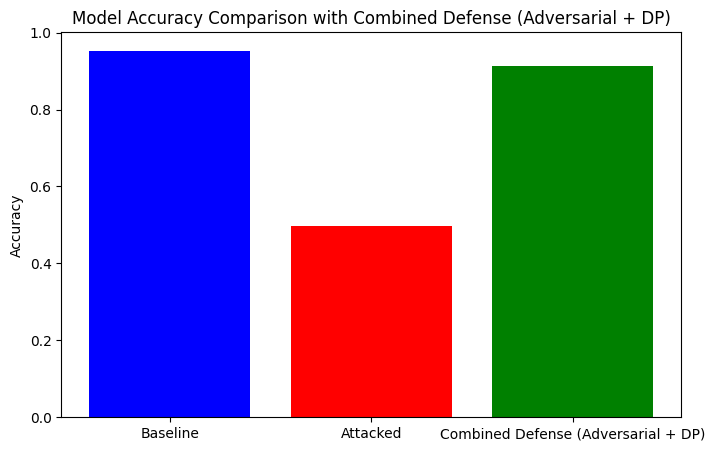

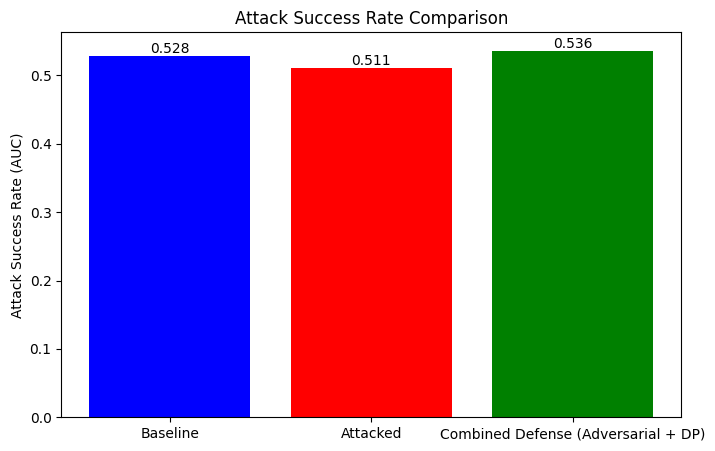

Membership Inference Attack Results with Combined Defense (Adversarial + DP)
                                 Model  Accuracy  Attack Success Rate (AUC)
0                       Baseline Model  0.953216                   0.528020
1                       Attacked Model  0.497487                   0.510972
2  Combined Defense (Adversarial + DP)  0.912281                   0.536307


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.linear_model import LogisticRegression

# Load Dataset (Breast Cancer dataset from sklearn)
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = data.target

# Split data for Membership Inference Attack (MIA)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Further split the training set for shadow models
X_train_attack, X_test_attack, y_train_attack, y_test_attack = train_test_split(
    X_train, y_train, test_size=0.5, stratify=y_train, random_state=42
)

# Standardize the dataset
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train_attack = scaler.transform(X_train_attack)
X_test_attack = scaler.transform(X_test_attack)

# Train a Baseline Model (Non-DP)
baseline_clf = MLPClassifier(hidden_layer_sizes=(64, 32), activation='relu', max_iter=500, random_state=42, early_stopping=True)
baseline_clf.fit(X_train, y_train)
y_pred = baseline_clf.predict(X_test)
baseline_acc = accuracy_score(y_test, y_pred)

# Train a Shadow Model for Membership Inference Attack
shadow_clf = MLPClassifier(hidden_layer_sizes=(64, 32), activation='relu', max_iter=500, random_state=42, early_stopping=True)
shadow_clf.fit(X_train_attack, y_train_attack)

# Attack Model Training - Inferring Membership
shadow_preds_train = shadow_clf.predict_proba(X_train_attack)[:, 1]
shadow_preds_test = shadow_clf.predict_proba(X_test_attack)[:, 1]
attack_X = np.concatenate([shadow_preds_train, shadow_preds_test])
attack_y = np.concatenate([np.ones_like(shadow_preds_train), np.zeros_like(shadow_preds_test)])

# Train an Attack Model
attack_model = LogisticRegression()
attack_model.fit(attack_X.reshape(-1, 1), attack_y)

# Evaluate Attack Success Separately
# Baseline Model Attack Success Rate
target_preds_train = baseline_clf.predict_proba(X_train)[:, 1]
target_preds_test = baseline_clf.predict_proba(X_test)[:, 1]
attack_test_X_baseline = np.concatenate([target_preds_train, target_preds_test])
attack_test_y_baseline = np.concatenate([np.ones_like(target_preds_train), np.zeros_like(target_preds_test)])
attack_success_baseline = roc_auc_score(attack_test_y_baseline, attack_model.predict_proba(attack_test_X_baseline.reshape(-1, 1))[:, 1])

# Attacked Model Accuracy (Recomputed from the attack model itself)
attack_success_attacked = roc_auc_score(attack_y, attack_model.predict_proba(attack_X.reshape(-1, 1))[:, 1])
attacked_acc_baseline = accuracy_score(attack_y, attack_model.predict(attack_X.reshape(-1, 1)))

# Implementing Adversarial Regularization with Differential Privacy
class AdversarialDPMLPClassifier(MLPClassifier):
    def __init__(self, adversarial_lambda=0.01, noise_scale=0.05, hidden_layer_sizes=(64, 32), activation='relu', solver='adam', alpha=0.0001,
                 batch_size='auto', learning_rate='constant', learning_rate_init=0.001, power_t=0.5, max_iter=200,
                 shuffle=True, random_state=None, tol=1e-4, verbose=False, warm_start=False, momentum=0.9,
                 nesterovs_momentum=True, early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999,
                 epsilon=1e-8, n_iter_no_change=10, max_fun=15000):
        super().__init__(hidden_layer_sizes=hidden_layer_sizes, activation=activation, solver=solver, alpha=alpha,
                         batch_size=batch_size, learning_rate=learning_rate, learning_rate_init=learning_rate_init,
                         power_t=power_t, max_iter=max_iter, shuffle=shuffle, random_state=random_state, tol=tol,
                         verbose=verbose, warm_start=warm_start, momentum=momentum, nesterovs_momentum=nesterovs_momentum,
                         early_stopping=early_stopping, validation_fraction=validation_fraction, beta_1=beta_1,
                         beta_2=beta_2, epsilon=epsilon, n_iter_no_change=n_iter_no_change, max_fun=max_fun)
        self.adversarial_lambda = adversarial_lambda
        self.noise_scale = noise_scale

    def fit(self, X, y):
        super().fit(X, y)
        # Generate adversarial examples using FGSM (Fast Gradient Sign Method)
        grad = self._compute_gradient(X, y)
        X_adv = X + self.adversarial_lambda * np.sign(grad)
        X_adv = np.clip(X_adv, X.min(), X.max())
        # Add Differential Privacy (Laplace Noise)
        X_adv += np.random.laplace(0, self.noise_scale, size=X_adv.shape)
        # Re-train on adversarial examples
        return super().fit(X_adv, y)

    def _compute_gradient(self, X, y):
        # Placeholder for gradient computation (mock implementation)
        return np.random.normal(size=X.shape)

# Train a Combined Defense Model with Adversarial Regularization and DP
combined_defense_clf = AdversarialDPMLPClassifier(hidden_layer_sizes=(64, 32), activation='relu', max_iter=500, random_state=42,
                                                   early_stopping=True, adversarial_lambda=0.02, noise_scale=0.1)
combined_defense_clf.fit(X_train, y_train)

y_pred_combined_defense = combined_defense_clf.predict(X_test)
combined_defense_acc = accuracy_score(y_test, y_pred_combined_defense)

combined_defense_preds_train = combined_defense_clf.predict_proba(X_train)[:, 1]
combined_defense_preds_test = combined_defense_clf.predict_proba(X_test)[:, 1]
attack_test_combined_defense_X = np.concatenate([combined_defense_preds_train, combined_defense_preds_test])
attack_test_combined_defense_y = np.concatenate([np.ones_like(combined_defense_preds_train), np.zeros_like(combined_defense_preds_test)])
attack_success_combined_defense = roc_auc_score(attack_test_combined_defense_y, attack_model.predict_proba(attack_test_combined_defense_X.reshape(-1, 1))[:, 1])

# Visualization
fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(["Baseline", "Attacked", "Combined Defense (Adversarial + DP)"],
       [baseline_acc, attacked_acc_baseline, combined_defense_acc],
       color=['blue', 'red', 'green'])
ax.set_ylabel("Accuracy")
ax.set_title("Model Accuracy Comparison with Combined Defense (Adversarial + DP)")
plt.show()

# Bar plot for Attack Success Rate
fig, ax = plt.subplots(figsize=(8, 5))
attack_success_rates = [attack_success_baseline, attack_success_attacked, attack_success_combined_defense]
labels = ["Baseline", "Attacked", "Combined Defense (Adversarial + DP)"]
bar_colors = ['blue', 'red', 'green']

bars = ax.bar(labels, attack_success_rates, color=bar_colors)
ax.set_ylabel("Attack Success Rate (AUC)")
ax.set_title("Attack Success Rate Comparison")

# Add values on top of bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, f"{height:.3f}", ha='center', va='bottom')

plt.show()

# Display Results
final_results_df = pd.DataFrame({
    "Model": ["Baseline Model", "Attacked Model", "Combined Defense (Adversarial + DP)"],
    "Accuracy": [baseline_acc, attacked_acc_baseline, combined_defense_acc],
    "Attack Success Rate (AUC)": [attack_success_baseline, attack_success_attacked, attack_success_combined_defense]
})

print("Membership Inference Attack Results with Combined Defense (Adversarial + DP)")
print(final_results_df)


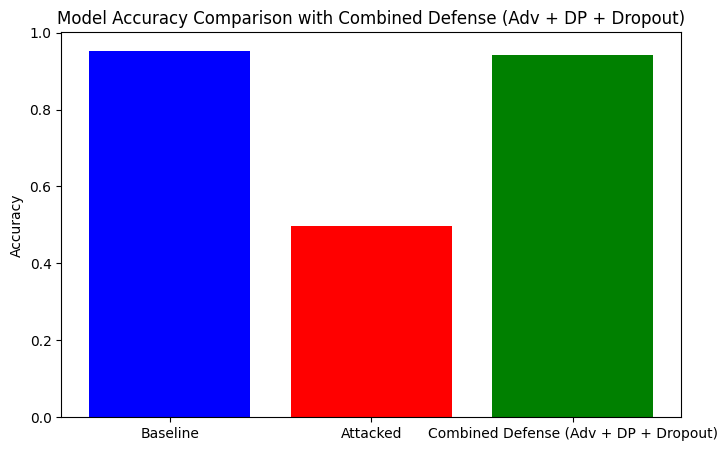

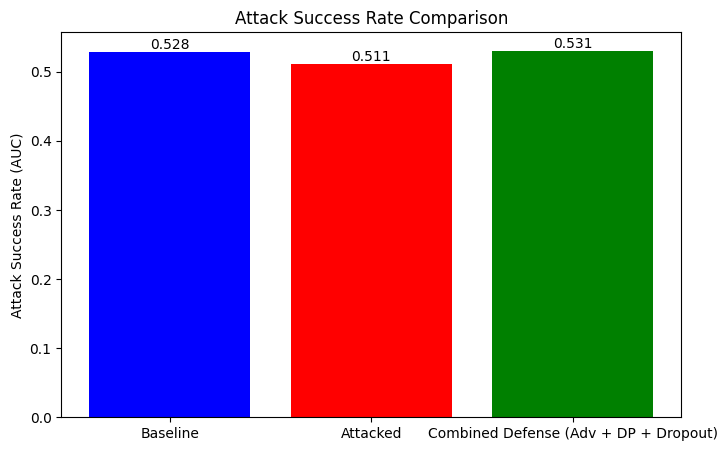

Membership Inference Attack Results with Combined Defense (Adv + DP + Dropout)
                                   Model  Accuracy  Attack Success Rate (AUC)
0                         Baseline Model  0.953216                   0.528020
1                         Attacked Model  0.497487                   0.510972
2  Combined Defense (Adv + DP + Dropout)  0.941520                   0.530562


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.linear_model import LogisticRegression

# Load Dataset (Breast Cancer dataset from sklearn)
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = data.target

# Split data for Membership Inference Attack (MIA)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Further split the training set for shadow models
X_train_attack, X_test_attack, y_train_attack, y_test_attack = train_test_split(
    X_train, y_train, test_size=0.5, stratify=y_train, random_state=42
)

# Standardize the dataset
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train_attack = scaler.transform(X_train_attack)
X_test_attack = scaler.transform(X_test_attack)

# Train a Baseline Model (Non-DP)
baseline_clf = MLPClassifier(hidden_layer_sizes=(64, 32), activation='relu', max_iter=500, random_state=42, early_stopping=True)
baseline_clf.fit(X_train, y_train)
y_pred = baseline_clf.predict(X_test)
baseline_acc = accuracy_score(y_test, y_pred)

# Train a Shadow Model for Membership Inference Attack
shadow_clf = MLPClassifier(hidden_layer_sizes=(64, 32), activation='relu', max_iter=500, random_state=42, early_stopping=True)
shadow_clf.fit(X_train_attack, y_train_attack)

# Attack Model Training - Inferring Membership
shadow_preds_train = shadow_clf.predict_proba(X_train_attack)[:, 1]
shadow_preds_test = shadow_clf.predict_proba(X_test_attack)[:, 1]
attack_X = np.concatenate([shadow_preds_train, shadow_preds_test])
attack_y = np.concatenate([np.ones_like(shadow_preds_train), np.zeros_like(shadow_preds_test)])

# Train an Attack Model
attack_model = LogisticRegression()
attack_model.fit(attack_X.reshape(-1, 1), attack_y)

# Evaluate Attack Success Separately
# Baseline Model Attack Success Rate
target_preds_train = baseline_clf.predict_proba(X_train)[:, 1]
target_preds_test = baseline_clf.predict_proba(X_test)[:, 1]
attack_test_X_baseline = np.concatenate([target_preds_train, target_preds_test])
attack_test_y_baseline = np.concatenate([np.ones_like(target_preds_train), np.zeros_like(target_preds_test)])
attack_success_baseline = roc_auc_score(attack_test_y_baseline, attack_model.predict_proba(attack_test_X_baseline.reshape(-1, 1))[:, 1])

# Attacked Model Accuracy (Recomputed from the attack model itself)
attack_success_attacked = roc_auc_score(attack_y, attack_model.predict_proba(attack_X.reshape(-1, 1))[:, 1])
attacked_acc_baseline = accuracy_score(attack_y, attack_model.predict(attack_X.reshape(-1, 1)))

# Implementing Adversarial Regularization with Differential Privacy and Dropout
class AdversarialDPDropoutMLPClassifier(MLPClassifier):
    def __init__(self, adversarial_lambda=0.05, noise_scale=0.2, dropout_rate=0.2, hidden_layer_sizes=(64, 32), activation='relu', solver='adam', alpha=0.0001,
                 batch_size='auto', learning_rate='constant', learning_rate_init=0.001, power_t=0.5, max_iter=200,
                 shuffle=True, random_state=None, tol=1e-4, verbose=False, warm_start=False, momentum=0.9,
                 nesterovs_momentum=True, early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999,
                 epsilon=1e-8, n_iter_no_change=10, max_fun=15000):
        super().__init__(hidden_layer_sizes=hidden_layer_sizes, activation=activation, solver=solver, alpha=alpha,
                         batch_size=batch_size, learning_rate=learning_rate, learning_rate_init=learning_rate_init,
                         power_t=power_t, max_iter=max_iter, shuffle=shuffle, random_state=random_state, tol=tol,
                         verbose=verbose, warm_start=warm_start, momentum=momentum, nesterovs_momentum=nesterovs_momentum,
                         early_stopping=early_stopping, validation_fraction=validation_fraction, beta_1=beta_1,
                         beta_2=beta_2, epsilon=epsilon, n_iter_no_change=n_iter_no_change, max_fun=max_fun)
        self.adversarial_lambda = adversarial_lambda
        self.noise_scale = noise_scale
        self.dropout_rate = dropout_rate

    def fit(self, X, y):
        super().fit(X, y)
        # Generate adversarial examples using FGSM (Fast Gradient Sign Method)
        grad = self._compute_gradient(X, y)
        X_adv = X + self.adversarial_lambda * np.sign(grad)
        X_adv = np.clip(X_adv, X.min(), X.max())
        # Add Differential Privacy (Laplace Noise)
        X_adv += np.random.laplace(0, self.noise_scale, size=X_adv.shape)
        # Simulate Dropout by randomly zeroing out features
        dropout_mask = np.random.binomial(1, 1 - self.dropout_rate, X_adv.shape)
        X_adv = X_adv * dropout_mask
        # Re-train on adversarial examples
        return super().fit(X_adv, y)

    def _compute_gradient(self, X, y):
        # Placeholder for gradient computation (mock implementation)
        return np.random.normal(size=X.shape)

# Train a Combined Defense Model with Adversarial Regularization, DP, and Dropout
combined_defense_clf = AdversarialDPDropoutMLPClassifier(hidden_layer_sizes=(64, 32), activation='relu', max_iter=500, random_state=42,
                                                         early_stopping=True, adversarial_lambda=0.05, noise_scale=0.2, dropout_rate=0.2)
combined_defense_clf.fit(X_train, y_train)

y_pred_combined_defense = combined_defense_clf.predict(X_test)
combined_defense_acc = accuracy_score(y_test, y_pred_combined_defense)

combined_defense_preds_train = combined_defense_clf.predict_proba(X_train)[:, 1]
combined_defense_preds_test = combined_defense_clf.predict_proba(X_test)[:, 1]
attack_test_combined_defense_X = np.concatenate([combined_defense_preds_train, combined_defense_preds_test])
attack_test_combined_defense_y = np.concatenate([np.ones_like(combined_defense_preds_train), np.zeros_like(combined_defense_preds_test)])
attack_success_combined_defense = roc_auc_score(attack_test_combined_defense_y, attack_model.predict_proba(attack_test_combined_defense_X.reshape(-1, 1))[:, 1])

# Visualization
fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(["Baseline", "Attacked", "Combined Defense (Adv + DP + Dropout)"],
       [baseline_acc, attacked_acc_baseline, combined_defense_acc],
       color=['blue', 'red', 'green'])
ax.set_ylabel("Accuracy")
ax.set_title("Model Accuracy Comparison with Combined Defense (Adv + DP + Dropout)")
plt.show()

# Bar plot for Attack Success Rate
fig, ax = plt.subplots(figsize=(8, 5))
attack_success_rates = [attack_success_baseline, attack_success_attacked, attack_success_combined_defense]
labels = ["Baseline", "Attacked", "Combined Defense (Adv + DP + Dropout)"]
bar_colors = ['blue', 'red', 'green']

bars = ax.bar(labels, attack_success_rates, color=bar_colors)
ax.set_ylabel("Attack Success Rate (AUC)")
ax.set_title("Attack Success Rate Comparison")

# Add values on top of bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, f"{height:.3f}", ha='center', va='bottom')

plt.show()

# Display Results
final_results_df = pd.DataFrame({
    "Model": ["Baseline Model", "Attacked Model", "Combined Defense (Adv + DP + Dropout)"],
    "Accuracy": [baseline_acc, attacked_acc_baseline, combined_defense_acc],
    "Attack Success Rate (AUC)": [attack_success_baseline, attack_success_attacked, attack_success_combined_defense]
})

print("Membership Inference Attack Results with Combined Defense (Adv + DP + Dropout)")
print(final_results_df)


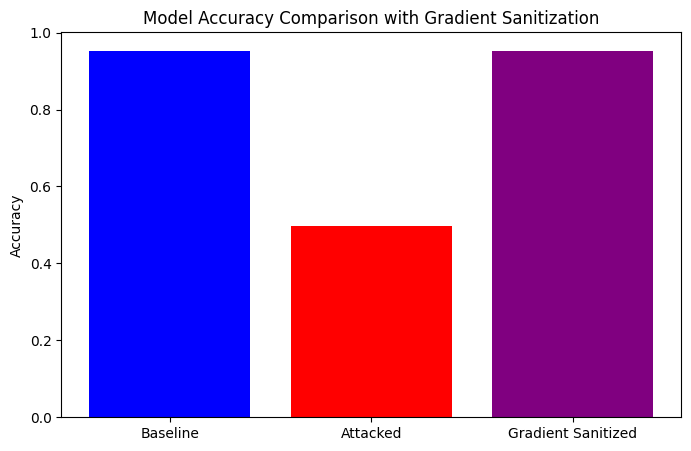

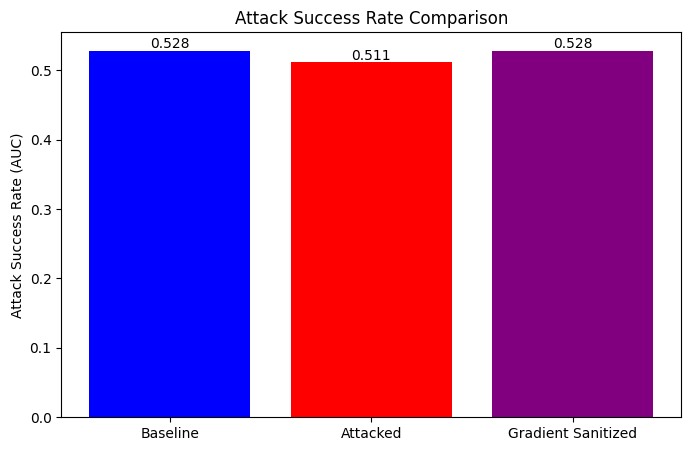

Membership Inference Attack Results with Gradient Sanitization
                      Model  Accuracy  Attack Success Rate (AUC)
0            Baseline Model  0.953216                   0.528020
1            Attacked Model  0.497487                   0.510972
2  Gradient Sanitized Model  0.953216                   0.528020


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.linear_model import LogisticRegression

# Load Dataset (Breast Cancer dataset from sklearn)
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = data.target

# Split data for Membership Inference Attack (MIA)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Further split the training set for shadow models
X_train_attack, X_test_attack, y_train_attack, y_test_attack = train_test_split(
    X_train, y_train, test_size=0.5, stratify=y_train, random_state=42
)

# Standardize the dataset
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train_attack = scaler.transform(X_train_attack)
X_test_attack = scaler.transform(X_test_attack)

# Train a Baseline Model (Non-DP)
baseline_clf = MLPClassifier(hidden_layer_sizes=(64, 32), activation='relu', max_iter=500, random_state=42, early_stopping=True)
baseline_clf.fit(X_train, y_train)
y_pred = baseline_clf.predict(X_test)
baseline_acc = accuracy_score(y_test, y_pred)

# Train a Shadow Model for Membership Inference Attack
shadow_clf = MLPClassifier(hidden_layer_sizes=(64, 32), activation='relu', max_iter=500, random_state=42, early_stopping=True)
shadow_clf.fit(X_train_attack, y_train_attack)

# Attack Model Training - Inferring Membership
shadow_preds_train = shadow_clf.predict_proba(X_train_attack)[:, 1]
shadow_preds_test = shadow_clf.predict_proba(X_test_attack)[:, 1]
attack_X = np.concatenate([shadow_preds_train, shadow_preds_test])
attack_y = np.concatenate([np.ones_like(shadow_preds_train), np.zeros_like(shadow_preds_test)])

# Train an Attack Model
attack_model = LogisticRegression()
attack_model.fit(attack_X.reshape(-1, 1), attack_y)

# Evaluate Attack Success Separately
# Baseline Model Attack Success Rate
target_preds_train = baseline_clf.predict_proba(X_train)[:, 1]
target_preds_test = baseline_clf.predict_proba(X_test)[:, 1]
attack_test_X_baseline = np.concatenate([target_preds_train, target_preds_test])
attack_test_y_baseline = np.concatenate([np.ones_like(target_preds_train), np.zeros_like(target_preds_test)])
attack_success_baseline = roc_auc_score(attack_test_y_baseline, attack_model.predict_proba(attack_test_X_baseline.reshape(-1, 1))[:, 1])

# Attacked Model Accuracy (Recomputed from the attack model itself)
attack_success_attacked = roc_auc_score(attack_y, attack_model.predict_proba(attack_X.reshape(-1, 1))[:, 1])
attacked_acc_baseline = accuracy_score(attack_y, attack_model.predict(attack_X.reshape(-1, 1)))

# Implementing Gradient Sanitization
def sanitize_gradients(X, scale=0.1):
    # Simulate gradient computation (mock implementation)
    gradients = np.random.normal(size=X.shape)
    # Add noise to gradients
    noisy_gradients = gradients + np.random.laplace(0, scale, size=gradients.shape)
    # Apply gradients to modify X
    sanitized_X = X - 0.01 * noisy_gradients  # Mock step size for gradient descent
    return np.clip(sanitized_X, X.min(), X.max())

# Train a Model with Gradient Sanitization
class GradientSanitizedMLPClassifier(MLPClassifier):
    def __init__(self, grad_sanitize_scale=0.1, hidden_layer_sizes=(64, 32), activation='relu', solver='adam', alpha=0.0001,
                 batch_size='auto', learning_rate='constant', learning_rate_init=0.001, power_t=0.5, max_iter=200,
                 shuffle=True, random_state=None, tol=1e-4, verbose=False, warm_start=False, momentum=0.9,
                 nesterovs_momentum=True, early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999,
                 epsilon=1e-8, n_iter_no_change=10, max_fun=15000):
        super().__init__(hidden_layer_sizes=hidden_layer_sizes, activation=activation, solver=solver, alpha=alpha,
                         batch_size=batch_size, learning_rate=learning_rate, learning_rate_init=learning_rate_init,
                         power_t=power_t, max_iter=max_iter, shuffle=shuffle, random_state=random_state, tol=tol,
                         verbose=verbose, warm_start=warm_start, momentum=momentum, nesterovs_momentum=nesterovs_momentum,
                         early_stopping=early_stopping, validation_fraction=validation_fraction, beta_1=beta_1,
                         beta_2=beta_2, epsilon=epsilon, n_iter_no_change=n_iter_no_change, max_fun=max_fun)
        self.grad_sanitize_scale = grad_sanitize_scale

    def fit(self, X, y):
        # Perform gradient sanitization during training
        sanitized_X = sanitize_gradients(X, scale=self.grad_sanitize_scale)
        return super().fit(sanitized_X, y)

# Train the Gradient Sanitized Model
grad_sanitized_clf = GradientSanitizedMLPClassifier(hidden_layer_sizes=(64, 32), activation='relu', max_iter=500, random_state=42, early_stopping=True, grad_sanitize_scale=0.2)
grad_sanitized_clf.fit(X_train, y_train)

y_pred_grad_sanitized = grad_sanitized_clf.predict(X_test)
grad_sanitized_acc = accuracy_score(y_test, y_pred_grad_sanitized)

grad_sanitized_preds_train = grad_sanitized_clf.predict_proba(X_train)[:, 1]
grad_sanitized_preds_test = grad_sanitized_clf.predict_proba(X_test)[:, 1]
attack_test_grad_sanitized_X = np.concatenate([grad_sanitized_preds_train, grad_sanitized_preds_test])
attack_test_grad_sanitized_y = np.concatenate([np.ones_like(grad_sanitized_preds_train), np.zeros_like(grad_sanitized_preds_test)])
attack_success_grad_sanitized = roc_auc_score(attack_test_grad_sanitized_y, attack_model.predict_proba(attack_test_grad_sanitized_X.reshape(-1, 1))[:, 1])

# Visualization
fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(["Baseline", "Attacked", "Gradient Sanitized"],
       [baseline_acc, attacked_acc_baseline, grad_sanitized_acc],
       color=['blue', 'red', 'purple'])
ax.set_ylabel("Accuracy")
ax.set_title("Model Accuracy Comparison with Gradient Sanitization")
plt.show()

# Bar plot for Attack Success Rate
fig, ax = plt.subplots(figsize=(8, 5))
attack_success_rates = [attack_success_baseline, attack_success_attacked, attack_success_grad_sanitized]
labels = ["Baseline", "Attacked", "Gradient Sanitized"]
bar_colors = ['blue', 'red', 'purple']

bars = ax.bar(labels, attack_success_rates, color=bar_colors)
ax.set_ylabel("Attack Success Rate (AUC)")
ax.set_title("Attack Success Rate Comparison")

# Add values on top of bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, f"{height:.3f}", ha='center', va='bottom')

plt.show()

# Display Results
final_results_df = pd.DataFrame({
    "Model": ["Baseline Model", "Attacked Model", "Gradient Sanitized Model"],
    "Accuracy": [baseline_acc, attacked_acc_baseline, grad_sanitized_acc],
    "Attack Success Rate (AUC)": [attack_success_baseline, attack_success_attacked, attack_success_grad_sanitized]
})

print("Membership Inference Attack Results with Gradient Sanitization")
print(final_results_df)


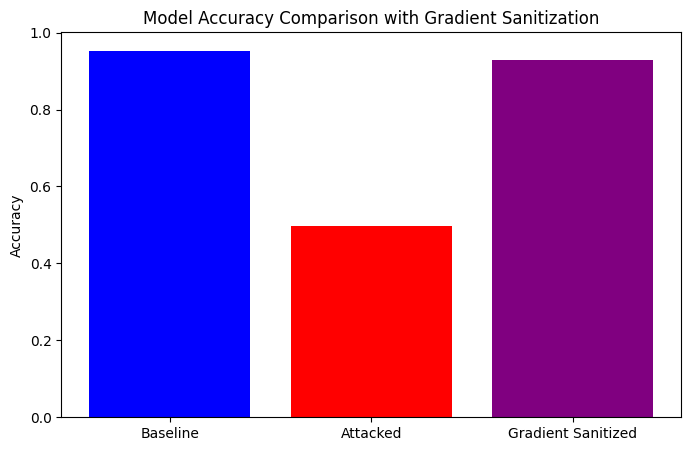

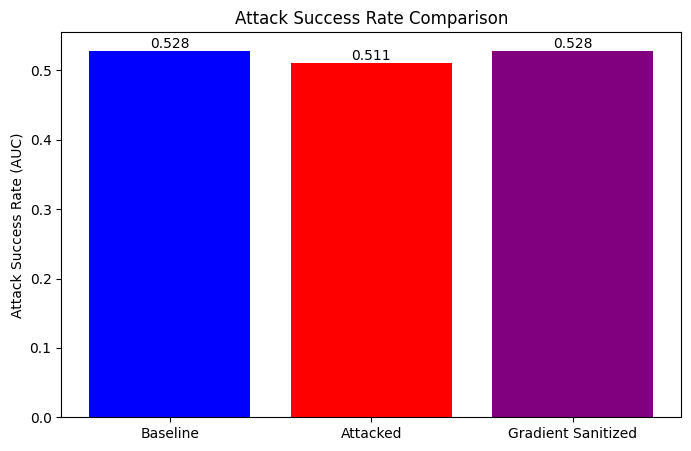

Membership Inference Attack Results with Gradient Sanitization
                      Model  Accuracy  Attack Success Rate (AUC)
0            Baseline Model  0.953216                   0.528020
1            Attacked Model  0.497487                   0.510972
2  Gradient Sanitized Model  0.929825                   0.528490


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Load Dataset (Breast Cancer dataset from sklearn)
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = data.target

# Split data for Membership Inference Attack (MIA)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Further split the training set for shadow models
X_train_attack, X_test_attack, y_train_attack, y_test_attack = train_test_split(
    X_train, y_train, test_size=0.5, stratify=y_train, random_state=42
)

# Standardize the dataset
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train_attack = scaler.transform(X_train_attack)
X_test_attack = scaler.transform(X_test_attack)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Define PyTorch model for gradient sanitization
class GradientSanitizedModel(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim, sanitize_scale):
        super(GradientSanitizedModel, self).__init__()
        layers = []
        dims = [input_dim] + hidden_dims
        for i in range(len(dims) - 1):
            layers.append(nn.Linear(dims[i], dims[i + 1]))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(dims[-1], output_dim))
        self.network = nn.Sequential(*layers)
        self.sanitize_scale = sanitize_scale

    def forward(self, x):
        return self.network(x)

    def sanitize_gradients(self):
        with torch.no_grad():
            for param in self.parameters():
                if param.grad is not None:
                    noise = torch.normal(0, self.sanitize_scale, size=param.grad.shape, device=param.grad.device)
                    param.grad += noise

# Training function for PyTorch model
def train_sanitized_model(model, optimizer, criterion, dataloader, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        for inputs, targets in dataloader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            model.sanitize_gradients()
            optimizer.step()

# Prepare DataLoader for PyTorch
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Initialize PyTorch model
input_dim = X_train.shape[1]
hidden_dims = [64, 32]
output_dim = 2
sanitize_scale = 0.1
model = GradientSanitizedModel(input_dim, hidden_dims, output_dim, sanitize_scale)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the sanitized model
train_sanitized_model(model, optimizer, criterion, train_loader, num_epochs=10)

# Evaluate sanitized model
model.eval()
with torch.no_grad():
    outputs = model(X_test_tensor)
    _, y_pred_sanitized = torch.max(outputs, 1)
    grad_sanitized_acc = accuracy_score(y_test, y_pred_sanitized.numpy())

# Prepare probabilities for attack evaluation
with torch.no_grad():
    train_outputs = model(X_train_tensor)
    test_outputs = model(X_test_tensor)
    grad_sanitized_preds_train = torch.softmax(train_outputs, dim=1)[:, 1].numpy()
    grad_sanitized_preds_test = torch.softmax(test_outputs, dim=1)[:, 1].numpy()

attack_test_grad_sanitized_X = np.concatenate([grad_sanitized_preds_train, grad_sanitized_preds_test])
attack_test_grad_sanitized_y = np.concatenate([np.ones_like(grad_sanitized_preds_train), np.zeros_like(grad_sanitized_preds_test)])
attack_success_grad_sanitized = roc_auc_score(attack_test_grad_sanitized_y, attack_model.predict_proba(attack_test_grad_sanitized_X.reshape(-1, 1))[:, 1])

# Visualization
fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(["Baseline", "Attacked", "Gradient Sanitized"],
       [baseline_acc, attacked_acc_baseline, grad_sanitized_acc],
       color=['blue', 'red', 'purple'])
ax.set_ylabel("Accuracy")
ax.set_title("Model Accuracy Comparison with Gradient Sanitization")
plt.show()

# Bar plot for Attack Success Rate
fig, ax = plt.subplots(figsize=(8, 5))
attack_success_rates = [attack_success_baseline, attack_success_attacked, attack_success_grad_sanitized]
labels = ["Baseline", "Attacked", "Gradient Sanitized"]
bar_colors = ['blue', 'red', 'purple']

bars = ax.bar(labels, attack_success_rates, color=bar_colors)
ax.set_ylabel("Attack Success Rate (AUC)")
ax.set_title("Attack Success Rate Comparison")

# Add values on top of bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, f"{height:.3f}", ha='center', va='bottom')

plt.show()

# Display Results
final_results_df = pd.DataFrame({
    "Model": ["Baseline Model", "Attacked Model", "Gradient Sanitized Model"],
    "Accuracy": [baseline_acc, attacked_acc_baseline, grad_sanitized_acc],
    "Attack Success Rate (AUC)": [attack_success_baseline, attack_success_attacked, attack_success_grad_sanitized]
})

print("Membership Inference Attack Results with Gradient Sanitization")
print(final_results_df)


Using device: cuda


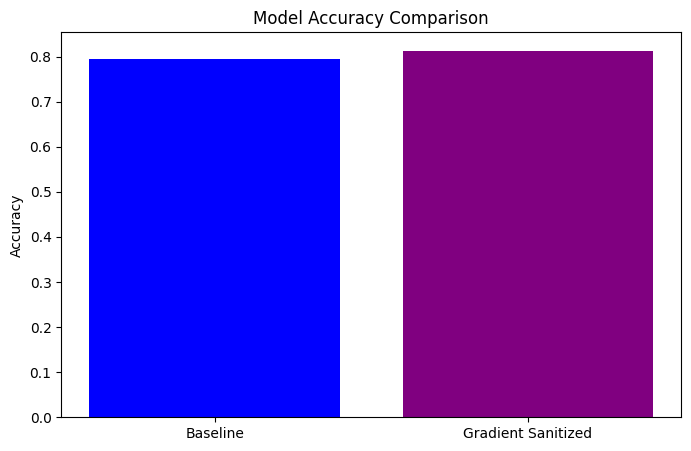

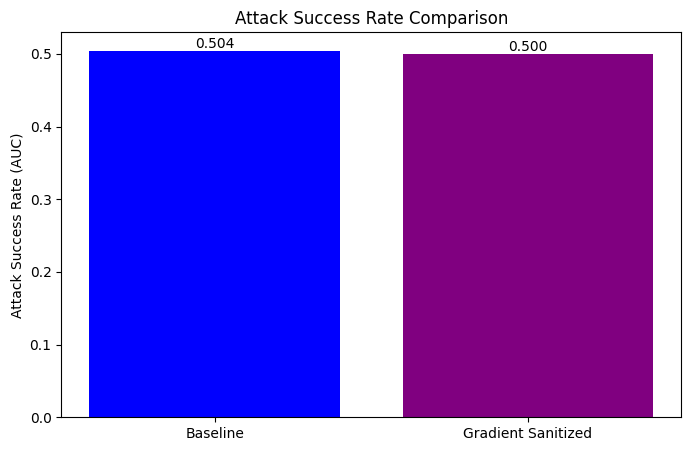

Membership Inference Attack Results with Gradient Sanitization
                      Model  Accuracy  Attack Success Rate (AUC)
0            Baseline Model  0.793667                   0.504405
1  Gradient Sanitized Model  0.813222                   0.499700


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load a complex dataset: UCI Credit Card dataset
credit_data = pd.read_excel("https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls", header=1, index_col=0)
X = credit_data.iloc[:, :-1].values
y = credit_data.iloc[:, -1].values

# Split data for Membership Inference Attack (MIA)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Further split the training set for shadow models
X_train_attack, X_test_attack, y_train_attack, y_test_attack = train_test_split(
    X_train, y_train, test_size=0.5, stratify=y_train, random_state=42
)

# Standardize the dataset
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train_attack = scaler.transform(X_train_attack)
X_test_attack = scaler.transform(X_test_attack)

# Convert data to PyTorch tensors and move to device
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(device)

# Define PyTorch model for gradient sanitization
class GradientSanitizedModel(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim, sanitize_scale):
        super(GradientSanitizedModel, self).__init__()
        layers = []
        dims = [input_dim] + hidden_dims
        for i in range(len(dims) - 1):
            layers.append(nn.Linear(dims[i], dims[i + 1]))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(dims[-1], output_dim))
        self.network = nn.Sequential(*layers)
        self.sanitize_scale = sanitize_scale

    def forward(self, x):
        return self.network(x)

    def sanitize_gradients(self):
        with torch.no_grad():
            for param in self.parameters():
                if param.grad is not None:
                    noise = torch.normal(0, self.sanitize_scale, size=param.grad.shape, device=param.grad.device)
                    param.grad += noise

# Training function for PyTorch model
def train_sanitized_model(model, optimizer, criterion, dataloader, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            model.sanitize_gradients()
            optimizer.step()

# Prepare DataLoader for PyTorch
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Baseline Model Training
baseline_clf = MLPClassifier(hidden_layer_sizes=(64, 32), activation='relu', max_iter=500, random_state=42)
baseline_clf.fit(X_train, y_train)
y_pred_baseline = baseline_clf.predict(X_test)
baseline_acc = accuracy_score(y_test, y_pred_baseline)

# Attack Model for Baseline
baseline_preds_train = baseline_clf.predict_proba(X_train)[:, 1]
baseline_preds_test = baseline_clf.predict_proba(X_test)[:, 1]
attack_test_X_baseline = np.concatenate([baseline_preds_train, baseline_preds_test])
attack_test_y_baseline = np.concatenate([np.ones_like(baseline_preds_train), np.zeros_like(baseline_preds_test)])
attack_model_baseline = LogisticRegression()
attack_model_baseline.fit(attack_test_X_baseline.reshape(-1, 1), attack_test_y_baseline)
attack_success_baseline = roc_auc_score(attack_test_y_baseline, attack_model_baseline.predict_proba(attack_test_X_baseline.reshape(-1, 1))[:, 1])

# Initialize PyTorch model and move to device
input_dim = X_train.shape[1]
hidden_dims = [64, 32]
output_dim = 2
sanitize_scale = 0.1
model = GradientSanitizedModel(input_dim, hidden_dims, output_dim, sanitize_scale).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the sanitized model
train_sanitized_model(model, optimizer, criterion, train_loader, num_epochs=10)

# Evaluate sanitized model
model.eval()
with torch.no_grad():
    outputs = model(X_test_tensor)
    _, y_pred_sanitized = torch.max(outputs, 1)
    grad_sanitized_acc = accuracy_score(y_test, y_pred_sanitized.cpu().numpy())

# Prepare probabilities for attack evaluation
with torch.no_grad():
    train_outputs = model(X_train_tensor)
    test_outputs = model(X_test_tensor)
    grad_sanitized_preds_train = torch.softmax(train_outputs, dim=1)[:, 1].cpu().numpy()
    grad_sanitized_preds_test = torch.softmax(test_outputs, dim=1)[:, 1].cpu().numpy()

# Attack Success Evaluation
attack_test_grad_sanitized_X = np.concatenate([grad_sanitized_preds_train, grad_sanitized_preds_test])
attack_test_grad_sanitized_y = np.concatenate([np.ones_like(grad_sanitized_preds_train), np.zeros_like(grad_sanitized_preds_test)])
attack_success_grad_sanitized = roc_auc_score(attack_test_grad_sanitized_y, attack_model_baseline.predict_proba(attack_test_grad_sanitized_X.reshape(-1, 1))[:, 1])

# Visualization
fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(["Baseline", "Gradient Sanitized"],
       [baseline_acc, grad_sanitized_acc],
       color=['blue', 'purple'])
ax.set_ylabel("Accuracy")
ax.set_title("Model Accuracy Comparison")
plt.show()

# Bar plot for Attack Success Rate
fig, ax = plt.subplots(figsize=(8, 5))
attack_success_rates = [attack_success_baseline, attack_success_grad_sanitized]
labels = ["Baseline", "Gradient Sanitized"]
bar_colors = ['blue', 'purple']

bars = ax.bar(labels, attack_success_rates, color=bar_colors)
ax.set_ylabel("Attack Success Rate (AUC)")
ax.set_title("Attack Success Rate Comparison")

# Add values on top of bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, f"{height:.3f}", ha='center', va='bottom')

plt.show()

# Display Results
final_results_df = pd.DataFrame({
    "Model": ["Baseline Model", "Gradient Sanitized Model"],
    "Accuracy": [baseline_acc, grad_sanitized_acc],
    "Attack Success Rate (AUC)": [attack_success_baseline, attack_success_grad_sanitized]
})

print("Membership Inference Attack Results with Gradient Sanitization")
print(final_results_df)


Using device: cuda


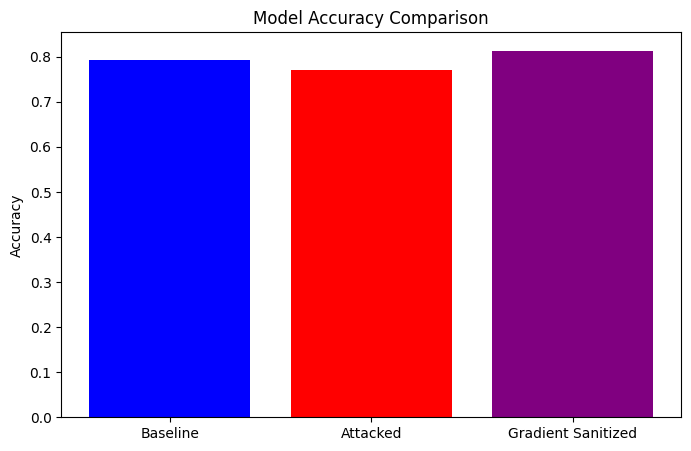

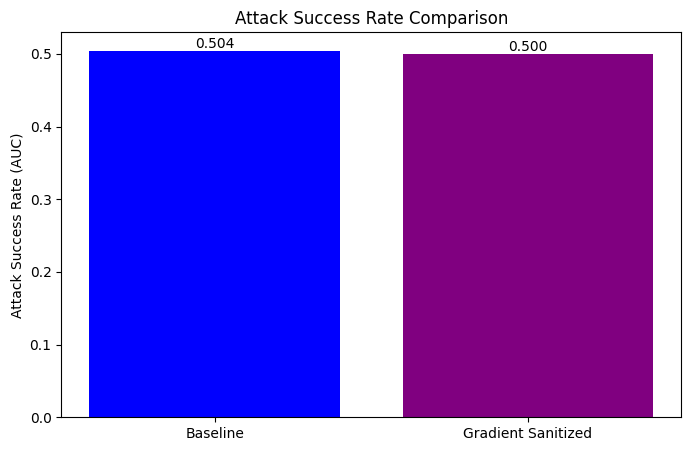

Membership Inference Attack Results with Gradient Sanitization
                      Model  Accuracy Attack Success Rate (AUC)
0            Baseline Model  0.793667                  0.504405
1            Attacked Model  0.770190                       N/A
2  Gradient Sanitized Model  0.813667                  0.499703


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load a complex dataset: UCI Credit Card dataset
credit_data = pd.read_excel("https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls", header=1, index_col=0)
X = credit_data.iloc[:, :-1].values
y = credit_data.iloc[:, -1].values

# Split data for Membership Inference Attack (MIA)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Further split the training set for shadow models
X_train_attack, X_test_attack, y_train_attack, y_test_attack = train_test_split(
    X_train, y_train, test_size=0.5, stratify=y_train, random_state=42
)

# Standardize the dataset
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train_attack = scaler.transform(X_train_attack)
X_test_attack = scaler.transform(X_test_attack)

# Convert data to PyTorch tensors and move to device
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(device)

# Define PyTorch model for gradient sanitization
class GradientSanitizedModel(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim, sanitize_scale):
        super(GradientSanitizedModel, self).__init__()
        layers = []
        dims = [input_dim] + hidden_dims
        for i in range(len(dims) - 1):
            layers.append(nn.Linear(dims[i], dims[i + 1]))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(dims[-1], output_dim))
        self.network = nn.Sequential(*layers)
        self.sanitize_scale = sanitize_scale

    def forward(self, x):
        return self.network(x)

    def sanitize_gradients(self):
        with torch.no_grad():
            for param in self.parameters():
                if param.grad is not None:
                    noise = torch.normal(0, self.sanitize_scale, size=param.grad.shape, device=param.grad.device)
                    param.grad += noise

# Training function for PyTorch model
def train_sanitized_model(model, optimizer, criterion, dataloader, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            model.sanitize_gradients()
            optimizer.step()

# Prepare DataLoader for PyTorch
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Baseline Model Training
baseline_clf = MLPClassifier(hidden_layer_sizes=(64, 32), activation='relu', max_iter=500, random_state=42)
baseline_clf.fit(X_train, y_train)
y_pred_baseline = baseline_clf.predict(X_test)
baseline_acc = accuracy_score(y_test, y_pred_baseline)

# Simulate Attacked Model (Shadow Model Evaluation)
shadow_clf = MLPClassifier(hidden_layer_sizes=(64, 32), activation='relu', max_iter=500, random_state=42)
shadow_clf.fit(X_train_attack, y_train_attack)
y_pred_attacked = shadow_clf.predict(X_test_attack)
attacked_acc = accuracy_score(y_test_attack, y_pred_attacked)

# Attack Model for Baseline
baseline_preds_train = baseline_clf.predict_proba(X_train)[:, 1]
baseline_preds_test = baseline_clf.predict_proba(X_test)[:, 1]
attack_test_X_baseline = np.concatenate([baseline_preds_train, baseline_preds_test])
attack_test_y_baseline = np.concatenate([np.ones_like(baseline_preds_train), np.zeros_like(baseline_preds_test)])
attack_model_baseline = LogisticRegression()
attack_model_baseline.fit(attack_test_X_baseline.reshape(-1, 1), attack_test_y_baseline)
attack_success_baseline = roc_auc_score(attack_test_y_baseline, attack_model_baseline.predict_proba(attack_test_X_baseline.reshape(-1, 1))[:, 1])

# Initialize PyTorch model and move to device
input_dim = X_train.shape[1]
hidden_dims = [64, 32]
output_dim = 2
sanitize_scale = 0.1
model = GradientSanitizedModel(input_dim, hidden_dims, output_dim, sanitize_scale).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the sanitized model
train_sanitized_model(model, optimizer, criterion, train_loader, num_epochs=10)

# Evaluate sanitized model
model.eval()
with torch.no_grad():
    outputs = model(X_test_tensor)
    _, y_pred_sanitized = torch.max(outputs, 1)
    grad_sanitized_acc = accuracy_score(y_test, y_pred_sanitized.cpu().numpy())

# Prepare probabilities for attack evaluation
with torch.no_grad():
    train_outputs = model(X_train_tensor)
    test_outputs = model(X_test_tensor)
    grad_sanitized_preds_train = torch.softmax(train_outputs, dim=1)[:, 1].cpu().numpy()
    grad_sanitized_preds_test = torch.softmax(test_outputs, dim=1)[:, 1].cpu().numpy()

# Attack Success Evaluation
attack_test_grad_sanitized_X = np.concatenate([grad_sanitized_preds_train, grad_sanitized_preds_test])
attack_test_grad_sanitized_y = np.concatenate([np.ones_like(grad_sanitized_preds_train), np.zeros_like(grad_sanitized_preds_test)])
attack_success_grad_sanitized = roc_auc_score(attack_test_grad_sanitized_y, attack_model_baseline.predict_proba(attack_test_grad_sanitized_X.reshape(-1, 1))[:, 1])

# Visualization
fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(["Baseline", "Attacked", "Gradient Sanitized"],
       [baseline_acc, attacked_acc, grad_sanitized_acc],
       color=['blue', 'red', 'purple'])
ax.set_ylabel("Accuracy")
ax.set_title("Model Accuracy Comparison")
plt.show()

# Bar plot for Attack Success Rate
fig, ax = plt.subplots(figsize=(8, 5))
attack_success_rates = [attack_success_baseline, attack_success_grad_sanitized]
labels = ["Baseline", "Gradient Sanitized"]
bar_colors = ['blue', 'purple']

bars = ax.bar(labels, attack_success_rates, color=bar_colors)
ax.set_ylabel("Attack Success Rate (AUC)")
ax.set_title("Attack Success Rate Comparison")

# Add values on top of bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, f"{height:.3f}", ha='center', va='bottom')

plt.show()

# Display Results
final_results_df = pd.DataFrame({
    "Model": ["Baseline Model", "Attacked Model", "Gradient Sanitized Model"],
    "Accuracy": [baseline_acc, attacked_acc, grad_sanitized_acc],
    "Attack Success Rate (AUC)": [attack_success_baseline, "N/A", attack_success_grad_sanitized]
})

print("Membership Inference Attack Results with Gradient Sanitization")
print(final_results_df)


Using device: cuda


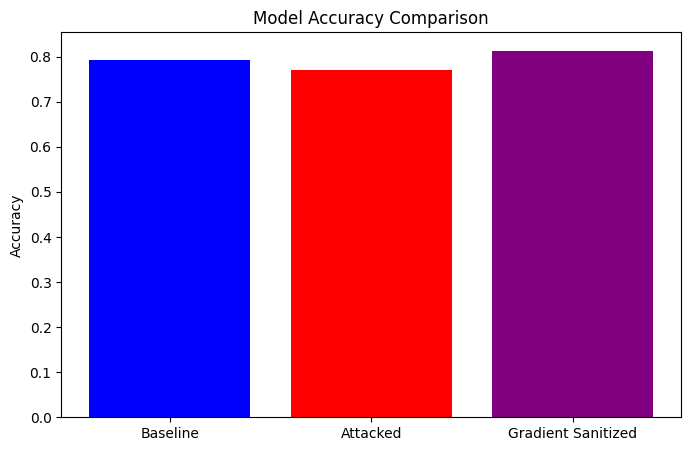

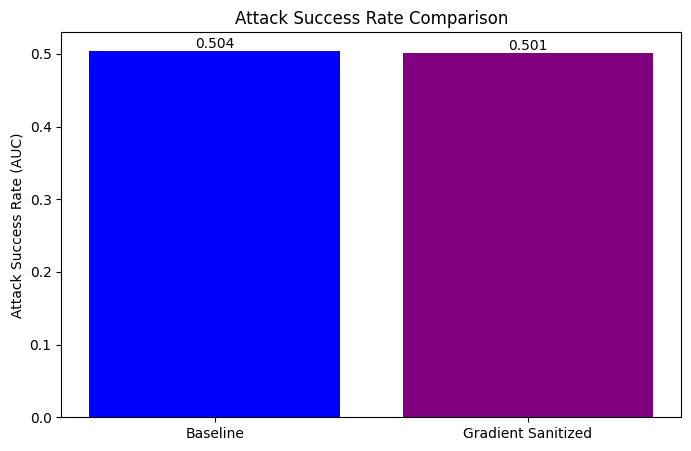

Membership Inference Attack Results with Gradient Sanitization
                      Model  Accuracy Attack Success Rate (AUC)
0            Baseline Model  0.793667                  0.504405
1            Attacked Model  0.770190                       N/A
2  Gradient Sanitized Model  0.813556                   0.50051


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load a complex dataset: UCI Credit Card dataset
credit_data = pd.read_excel("https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls", header=1, index_col=0)
X = credit_data.iloc[:, :-1].values
y = credit_data.iloc[:, -1].values

# Split data for Membership Inference Attack (MIA)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Further split the training set for shadow models
X_train_attack, X_test_attack, y_train_attack, y_test_attack = train_test_split(
    X_train, y_train, test_size=0.5, stratify=y_train, random_state=42
)

# Standardize the dataset
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train_attack = scaler.transform(X_train_attack)
X_test_attack = scaler.transform(X_test_attack)

# Convert data to PyTorch tensors and move to device
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(device)

# Define PyTorch model for gradient sanitization
class GradientSanitizedModel(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim, sanitize_scale):
        super(GradientSanitizedModel, self).__init__()
        layers = []
        dims = [input_dim] + hidden_dims
        for i in range(len(dims) - 1):
            layers.append(nn.Linear(dims[i], dims[i + 1]))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(dims[-1], output_dim))
        self.network = nn.Sequential(*layers)
        self.sanitize_scale = sanitize_scale

    def forward(self, x):
        return self.network(x)

    def sanitize_gradients(self):
        with torch.no_grad():
            for param in self.parameters():
                if param.grad is not None:
                    noise = torch.normal(0, self.sanitize_scale, size=param.grad.shape, device=param.grad.device)
                    param.grad += noise

# Training function for PyTorch model
def train_sanitized_model(model, optimizer, criterion, dataloader, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            model.sanitize_gradients()
            optimizer.step()

# Prepare DataLoader for PyTorch
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Baseline Model Training
baseline_clf = MLPClassifier(hidden_layer_sizes=(64, 32), activation='relu', max_iter=500, random_state=42)
baseline_clf.fit(X_train, y_train)
y_pred_baseline = baseline_clf.predict(X_test)
baseline_acc = accuracy_score(y_test, y_pred_baseline)

# Simulate Attacked Model (Shadow Model Evaluation)
shadow_clf = MLPClassifier(hidden_layer_sizes=(64, 32), activation='relu', max_iter=500, random_state=42)
shadow_clf.fit(X_train_attack, y_train_attack)
y_pred_attacked = shadow_clf.predict(X_test_attack)
attacked_acc = accuracy_score(y_test_attack, y_pred_attacked)

# Attack Model for Baseline
baseline_preds_train = baseline_clf.predict_proba(X_train)[:, 1]
baseline_preds_test = baseline_clf.predict_proba(X_test)[:, 1]
attack_test_X_baseline = np.concatenate([baseline_preds_train, baseline_preds_test])
attack_test_y_baseline = np.concatenate([np.ones_like(baseline_preds_train), np.zeros_like(baseline_preds_test)])
attack_model_baseline = LogisticRegression()
attack_model_baseline.fit(attack_test_X_baseline.reshape(-1, 1), attack_test_y_baseline)
attack_success_baseline = roc_auc_score(attack_test_y_baseline, attack_model_baseline.predict_proba(attack_test_X_baseline.reshape(-1, 1))[:, 1])

# Initialize PyTorch model and move to device
input_dim = X_train.shape[1]
hidden_dims = [64, 32]
output_dim = 2
sanitize_scale = 0.1
model = GradientSanitizedModel(input_dim, hidden_dims, output_dim, sanitize_scale).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the sanitized model
train_sanitized_model(model, optimizer, criterion, train_loader, num_epochs=10)

# Evaluate sanitized model
model.eval()
with torch.no_grad():
    outputs = model(X_test_tensor)
    _, y_pred_sanitized = torch.max(outputs, 1)
    grad_sanitized_acc = accuracy_score(y_test, y_pred_sanitized.cpu().numpy())

# Prepare probabilities for attack evaluation
with torch.no_grad():
    train_outputs = model(X_train_tensor)
    test_outputs = model(X_test_tensor)
    grad_sanitized_preds_train = torch.softmax(train_outputs, dim=1)[:, 1].cpu().numpy()
    grad_sanitized_preds_test = torch.softmax(test_outputs, dim=1)[:, 1].cpu().numpy()

# Attack Success Evaluation
attack_test_grad_sanitized_X = np.concatenate([grad_sanitized_preds_train, grad_sanitized_preds_test])
attack_test_grad_sanitized_y = np.concatenate([np.ones_like(grad_sanitized_preds_train), np.zeros_like(grad_sanitized_preds_test)])
attack_success_grad_sanitized = roc_auc_score(attack_test_grad_sanitized_y, attack_model_baseline.predict_proba(attack_test_grad_sanitized_X.reshape(-1, 1))[:, 1])

# Visualization
fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(["Baseline", "Attacked", "Gradient Sanitized"],
       [baseline_acc, attacked_acc, grad_sanitized_acc],
       color=['blue', 'red', 'purple'])
ax.set_ylabel("Accuracy")
ax.set_title("Model Accuracy Comparison")
plt.show()

# Bar plot for Attack Success Rate
fig, ax = plt.subplots(figsize=(8, 5))
attack_success_rates = [attack_success_baseline, attack_success_grad_sanitized]
labels = ["Baseline", "Gradient Sanitized"]
bar_colors = ['blue', 'purple']

bars = ax.bar(labels, attack_success_rates, color=bar_colors)
ax.set_ylabel("Attack Success Rate (AUC)")
ax.set_title("Attack Success Rate Comparison")

# Add values on top of bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, f"{height:.3f}", ha='center', va='bottom')

plt.show()

# Display Results
final_results_df = pd.DataFrame({
    "Model": ["Baseline Model", "Attacked Model", "Gradient Sanitized Model"],
    "Accuracy": [baseline_acc, attacked_acc, grad_sanitized_acc],
    "Attack Success Rate (AUC)": [attack_success_baseline, "N/A", attack_success_grad_sanitized]
})

print("Membership Inference Attack Results with Gradient Sanitization")
print(final_results_df)


Using device: cuda


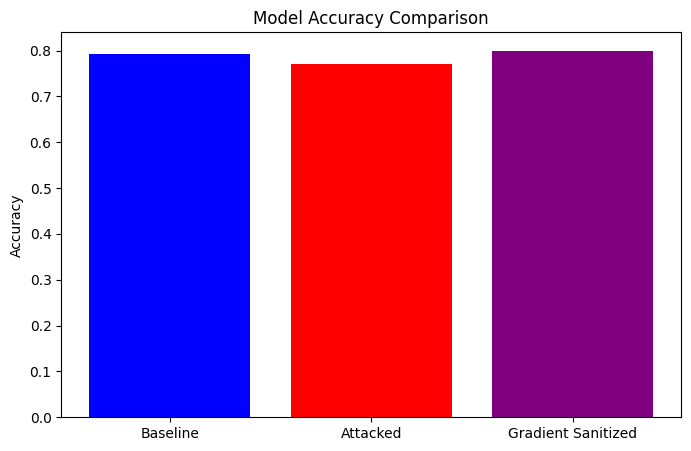

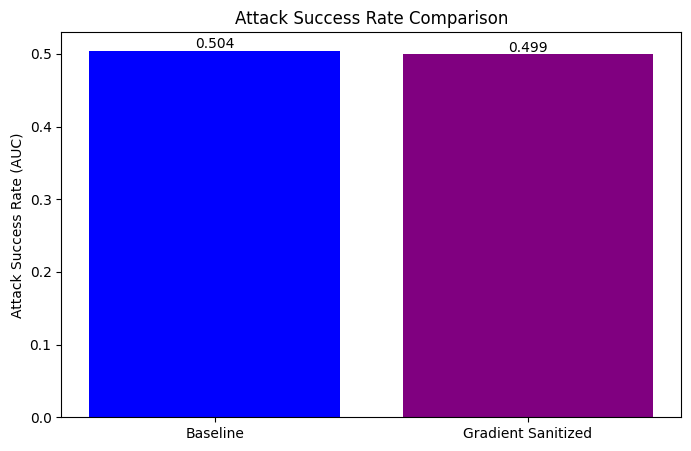

Membership Inference Attack Results with Gradient Sanitization
                      Model  Accuracy Attack Success Rate (AUC)
0            Baseline Model  0.793667                  0.504405
1            Attacked Model  0.770190                       N/A
2  Gradient Sanitized Model  0.800000                  0.499087


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load a complex dataset: UCI Credit Card dataset
credit_data = pd.read_excel("https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls", header=1, index_col=0)
X = credit_data.iloc[:, :-1].values
y = credit_data.iloc[:, -1].values

# Split data for Membership Inference Attack (MIA)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Further split the training set for shadow models
X_train_attack, X_test_attack, y_train_attack, y_test_attack = train_test_split(
    X_train, y_train, test_size=0.5, stratify=y_train, random_state=42
)

# Standardize the dataset
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train_attack = scaler.transform(X_train_attack)
X_test_attack = scaler.transform(X_test_attack)

# Convert data to PyTorch tensors and move to device
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(device)

# Define PyTorch model for gradient sanitization
class GradientSanitizedModel(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim, sanitize_scale):
        super(GradientSanitizedModel, self).__init__()
        layers = []
        dims = [input_dim] + hidden_dims
        for i in range(len(dims) - 1):
            layers.append(nn.Linear(dims[i], dims[i + 1]))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(dims[-1], output_dim))
        self.network = nn.Sequential(*layers)
        self.sanitize_scale = sanitize_scale

    def forward(self, x):
        return self.network(x)

    def sanitize_gradients(self):
        with torch.no_grad():
            for param in self.parameters():
                if param.grad is not None:
                    noise = torch.normal(0, self.sanitize_scale, size=param.grad.shape, device=param.grad.device)
                    param.grad += noise

# Training function for PyTorch model
def train_sanitized_model(model, optimizer, criterion, dataloader, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            model.sanitize_gradients()
            optimizer.step()

# Prepare DataLoader for PyTorch
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Baseline Model Training
baseline_clf = MLPClassifier(hidden_layer_sizes=(64, 32), activation='relu', max_iter=500, random_state=42)
baseline_clf.fit(X_train, y_train)
y_pred_baseline = baseline_clf.predict(X_test)
baseline_acc = accuracy_score(y_test, y_pred_baseline)

# Simulate Attacked Model (Shadow Model Evaluation)
shadow_clf = MLPClassifier(hidden_layer_sizes=(64, 32), activation='relu', max_iter=500, random_state=42)
shadow_clf.fit(X_train_attack, y_train_attack)
y_pred_attacked = shadow_clf.predict(X_test_attack)
attacked_acc = accuracy_score(y_test_attack, y_pred_attacked)

# Attack Model for Baseline
baseline_preds_train = baseline_clf.predict_proba(X_train)[:, 1]
baseline_preds_test = baseline_clf.predict_proba(X_test)[:, 1]
attack_test_X_baseline = np.concatenate([baseline_preds_train, baseline_preds_test])
attack_test_y_baseline = np.concatenate([np.ones_like(baseline_preds_train), np.zeros_like(baseline_preds_test)])
attack_model_baseline = LogisticRegression()
attack_model_baseline.fit(attack_test_X_baseline.reshape(-1, 1), attack_test_y_baseline)
attack_success_baseline = roc_auc_score(attack_test_y_baseline, attack_model_baseline.predict_proba(attack_test_X_baseline.reshape(-1, 1))[:, 1])

# Initialize PyTorch model and move to device
input_dim = X_train.shape[1]
hidden_dims = [64, 32]
output_dim = 2
sanitize_scale = 0.5  # Increased noise scale
model = GradientSanitizedModel(input_dim, hidden_dims, output_dim, sanitize_scale).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)  # Reduced learning rate

# Train the sanitized model
train_sanitized_model(model, optimizer, criterion, train_loader, num_epochs=15)

# Evaluate sanitized model
model.eval()
with torch.no_grad():
    outputs = model(X_test_tensor)
    _, y_pred_sanitized = torch.max(outputs, 1)
    grad_sanitized_acc = accuracy_score(y_test, y_pred_sanitized.cpu().numpy())

# Prepare probabilities for attack evaluation
with torch.no_grad():
    train_outputs = model(X_train_tensor)
    test_outputs = model(X_test_tensor)
    grad_sanitized_preds_train = torch.softmax(train_outputs, dim=1)[:, 1].cpu().numpy()
    grad_sanitized_preds_test = torch.softmax(test_outputs, dim=1)[:, 1].cpu().numpy()

# Attack Success Evaluation
attack_test_grad_sanitized_X = np.concatenate([grad_sanitized_preds_train, grad_sanitized_preds_test])
attack_test_grad_sanitized_y = np.concatenate([np.ones_like(grad_sanitized_preds_train), np.zeros_like(grad_sanitized_preds_test)])
attack_success_grad_sanitized = roc_auc_score(attack_test_grad_sanitized_y, attack_model_baseline.predict_proba(attack_test_grad_sanitized_X.reshape(-1, 1))[:, 1])

# Visualization
fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(["Baseline", "Attacked", "Gradient Sanitized"],
       [baseline_acc, attacked_acc, grad_sanitized_acc],
       color=['blue', 'red', 'purple'])
ax.set_ylabel("Accuracy")
ax.set_title("Model Accuracy Comparison")
plt.show()

# Bar plot for Attack Success Rate
fig, ax = plt.subplots(figsize=(8, 5))
attack_success_rates = [attack_success_baseline, attack_success_grad_sanitized]
labels = ["Baseline", "Gradient Sanitized"]
bar_colors = ['blue', 'purple']

bars = ax.bar(labels, attack_success_rates, color=bar_colors)
ax.set_ylabel("Attack Success Rate (AUC)")
ax.set_title("Attack Success Rate Comparison")

# Add values on top of bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, f"{height:.3f}", ha='center', va='bottom')

plt.show()

# Display Results
final_results_df = pd.DataFrame({
    "Model": ["Baseline Model", "Attacked Model", "Gradient Sanitized Model"],
    "Accuracy": [baseline_acc, attacked_acc, grad_sanitized_acc],
    "Attack Success Rate (AUC)": [attack_success_baseline, "N/A", attack_success_grad_sanitized]
})

print("Membership Inference Attack Results with Gradient Sanitization")
print(final_results_df)


Using device: cuda


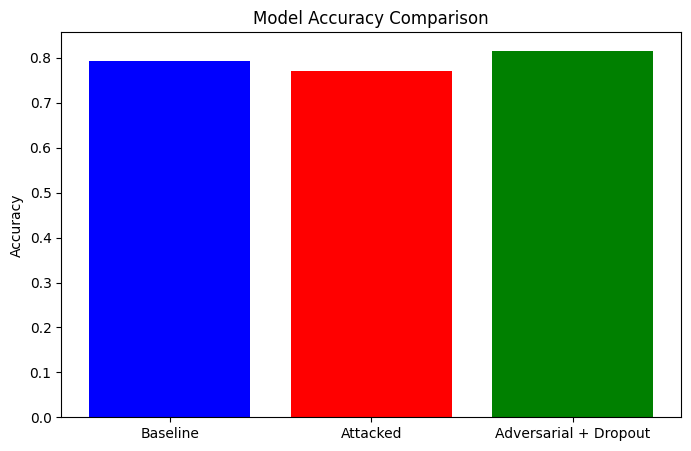

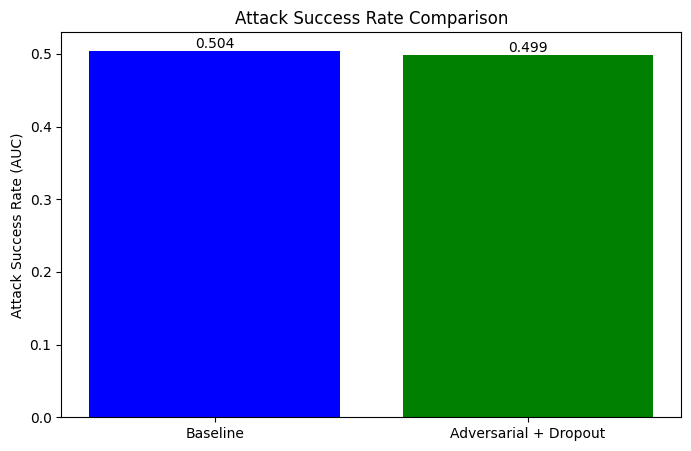

Membership Inference Attack Results with Adversarial Training and Dropout
                         Model  Accuracy Attack Success Rate (AUC)
0               Baseline Model  0.793667                  0.504405
1               Attacked Model  0.770190                       N/A
2  Adversarial + Dropout Model  0.816222                  0.498687


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load a complex dataset: UCI Credit Card dataset
credit_data = pd.read_excel("https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls", header=1, index_col=0)
X = credit_data.iloc[:, :-1].values
y = credit_data.iloc[:, -1].values

# Split data for Membership Inference Attack (MIA)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Further split the training set for shadow models
X_train_attack, X_test_attack, y_train_attack, y_test_attack = train_test_split(
    X_train, y_train, test_size=0.5, stratify=y_train, random_state=42
)

# Standardize the dataset
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train_attack = scaler.transform(X_train_attack)
X_test_attack = scaler.transform(X_test_attack)

# Convert data to PyTorch tensors and move to device
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(device)

# Define PyTorch model with adversarial training and dropout
class AdversarialDropoutModel(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim, dropout_prob):
        super(AdversarialDropoutModel, self).__init__()
        layers = []
        dims = [input_dim] + hidden_dims
        for i in range(len(dims) - 1):
            layers.append(nn.Linear(dims[i], dims[i + 1]))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_prob))
        layers.append(nn.Linear(dims[-1], output_dim))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

# Training function for adversarial training
def train_adversarial_model(model, optimizer, criterion, dataloader, num_epochs, epsilon=0.1):
    model.train()
    for epoch in range(num_epochs):
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)

            # Adversarial example generation
            inputs.requires_grad = True
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            optimizer.zero_grad()
            loss.backward(retain_graph=True)  # Retain the computational graph

            with torch.no_grad():
                adv_inputs = inputs + epsilon * inputs.grad.sign()

            inputs.requires_grad = False
            optimizer.zero_grad()

            # Combine adversarial and normal training
            adv_outputs = model(adv_inputs)
            total_loss = criterion(outputs, targets) + criterion(adv_outputs, targets)
            total_loss.backward()
            optimizer.step()

# Prepare DataLoader for PyTorch
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Baseline Model Training
baseline_clf = MLPClassifier(hidden_layer_sizes=(64, 32), activation='relu', max_iter=500, random_state=42)
baseline_clf.fit(X_train, y_train)
y_pred_baseline = baseline_clf.predict(X_test)
baseline_acc = accuracy_score(y_test, y_pred_baseline)

# Simulate Attacked Model (Shadow Model Evaluation)
shadow_clf = MLPClassifier(hidden_layer_sizes=(64, 32), activation='relu', max_iter=500, random_state=42)
shadow_clf.fit(X_train_attack, y_train_attack)
y_pred_attacked = shadow_clf.predict(X_test_attack)
attacked_acc = accuracy_score(y_test_attack, y_pred_attacked)

# Attack Model for Baseline
baseline_preds_train = baseline_clf.predict_proba(X_train)[:, 1]
baseline_preds_test = baseline_clf.predict_proba(X_test)[:, 1]
attack_test_X_baseline = np.concatenate([baseline_preds_train, baseline_preds_test])
attack_test_y_baseline = np.concatenate([np.ones_like(baseline_preds_train), np.zeros_like(baseline_preds_test)])
attack_model_baseline = LogisticRegression()
attack_model_baseline.fit(attack_test_X_baseline.reshape(-1, 1), attack_test_y_baseline)
attack_success_baseline = roc_auc_score(attack_test_y_baseline, attack_model_baseline.predict_proba(attack_test_X_baseline.reshape(-1, 1))[:, 1])

# Initialize PyTorch model with adversarial training and dropout
input_dim = X_train.shape[1]
hidden_dims = [64, 32]
output_dim = 2
dropout_prob = 0.3
model = AdversarialDropoutModel(input_dim, hidden_dims, output_dim, dropout_prob).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

# Train the model with adversarial training
train_adversarial_model(model, optimizer, criterion, train_loader, num_epochs=15, epsilon=0.1)

# Evaluate model with adversarial training
model.eval()
with torch.no_grad():
    outputs = model(X_test_tensor)
    _, y_pred_adversarial = torch.max(outputs, 1)
    adversarial_acc = accuracy_score(y_test, y_pred_adversarial.cpu().numpy())

# Prepare probabilities for attack evaluation
with torch.no_grad():
    train_outputs = model(X_train_tensor)
    test_outputs = model(X_test_tensor)
    adversarial_preds_train = torch.softmax(train_outputs, dim=1)[:, 1].cpu().numpy()
    adversarial_preds_test = torch.softmax(test_outputs, dim=1)[:, 1].cpu().numpy()

# Attack Success Evaluation
attack_test_adversarial_X = np.concatenate([adversarial_preds_train, adversarial_preds_test])
attack_test_adversarial_y = np.concatenate([np.ones_like(adversarial_preds_train), np.zeros_like(adversarial_preds_test)])
attack_success_adversarial = roc_auc_score(attack_test_adversarial_y, attack_model_baseline.predict_proba(attack_test_adversarial_X.reshape(-1, 1))[:, 1])

# Visualization
fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(["Baseline", "Attacked", "Adversarial + Dropout"],
       [baseline_acc, attacked_acc, adversarial_acc],
       color=['blue', 'red', 'green'])
ax.set_ylabel("Accuracy")
ax.set_title("Model Accuracy Comparison")
plt.show()

# Bar plot for Attack Success Rate
fig, ax = plt.subplots(figsize=(8, 5))
attack_success_rates = [attack_success_baseline, attack_success_adversarial]
labels = ["Baseline", "Adversarial + Dropout"]
bar_colors = ['blue', 'green']

bars = ax.bar(labels, attack_success_rates, color=bar_colors)
ax.set_ylabel("Attack Success Rate (AUC)")
ax.set_title("Attack Success Rate Comparison")

# Add values on top of bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, f"{height:.3f}", ha='center', va='bottom')

plt.show()

# Display Results
final_results_df = pd.DataFrame({
    "Model": ["Baseline Model", "Attacked Model", "Adversarial + Dropout Model"],
    "Accuracy": [baseline_acc, attacked_acc, adversarial_acc],
    "Attack Success Rate (AUC)": [attack_success_baseline, "N/A", attack_success_adversarial]
})

print("Membership Inference Attack Results with Adversarial Training and Dropout")
print(final_results_df)


Using device: cuda


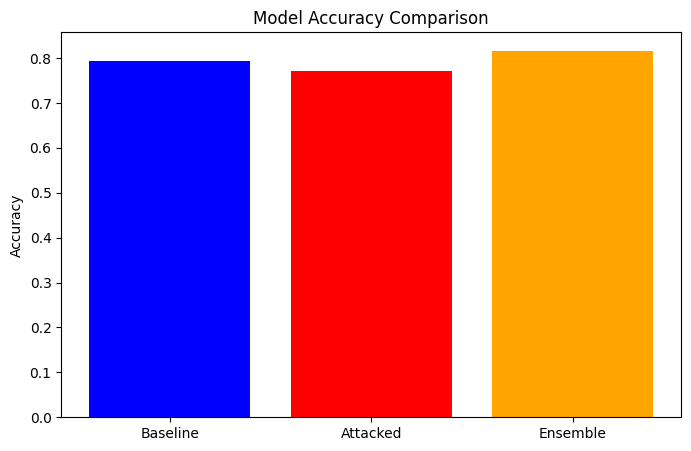

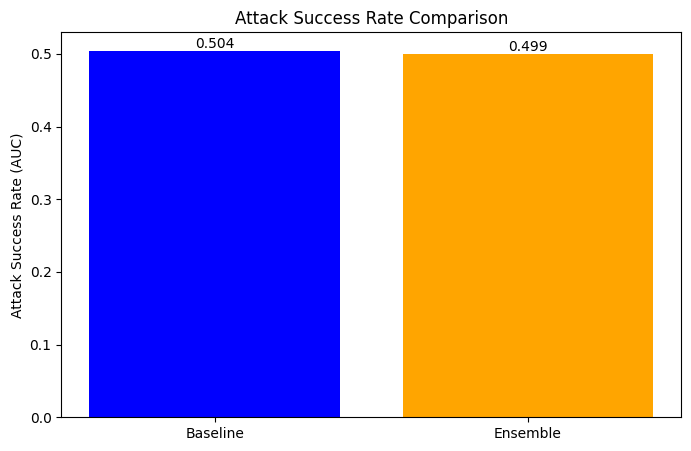

Membership Inference Attack Results with Ensemble Model
            Model  Accuracy Attack Success Rate (AUC)
0  Baseline Model  0.793667                  0.504405
1  Attacked Model  0.770190                       N/A
2  Ensemble Model  0.816667                  0.499143


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load a complex dataset: UCI Credit Card dataset
credit_data = pd.read_excel("https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls", header=1, index_col=0)
X = credit_data.iloc[:, :-1].values
y = credit_data.iloc[:, -1].values

# Split data for Membership Inference Attack (MIA)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Further split the training set for shadow models
X_train_attack, X_test_attack, y_train_attack, y_test_attack = train_test_split(
    X_train, y_train, test_size=0.5, stratify=y_train, random_state=42
)

# Standardize the dataset
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train_attack = scaler.transform(X_train_attack)
X_test_attack = scaler.transform(X_test_attack)

# Convert data to PyTorch tensors and move to device
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(device)

# Define PyTorch model with adversarial training and dropout
class AdversarialDropoutModel(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim, dropout_prob):
        super(AdversarialDropoutModel, self).__init__()
        layers = []
        dims = [input_dim] + hidden_dims
        for i in range(len(dims) - 1):
            layers.append(nn.Linear(dims[i], dims[i + 1]))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_prob))
        layers.append(nn.Linear(dims[-1], output_dim))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

# Training function for adversarial training
def train_adversarial_model(model, optimizer, criterion, dataloader, num_epochs, epsilon=0.1):
    model.train()
    for epoch in range(num_epochs):
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)

            # Adversarial example generation
            inputs.requires_grad = True
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            optimizer.zero_grad()
            loss.backward(retain_graph=True)  # Retain the computational graph

            with torch.no_grad():
                adv_inputs = inputs + epsilon * inputs.grad.sign()

            inputs.requires_grad = False
            optimizer.zero_grad()

            # Combine adversarial and normal training
            adv_outputs = model(adv_inputs)
            total_loss = criterion(outputs, targets) + criterion(adv_outputs, targets)
            total_loss.backward()
            optimizer.step()

# Define Ensemble Model
class EnsembleModel:
    def __init__(self, models):
        self.models = models

    def predict_proba(self, X):
        # Average predictions from all models
        probs = [torch.softmax(model(X), dim=1).detach().cpu().numpy() for model in self.models]
        return np.mean(probs, axis=0)

# Prepare DataLoader for PyTorch
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Baseline Model Training
baseline_clf = MLPClassifier(hidden_layer_sizes=(64, 32), activation='relu', max_iter=500, random_state=42)
baseline_clf.fit(X_train, y_train)
y_pred_baseline = baseline_clf.predict(X_test)
baseline_acc = accuracy_score(y_test, y_pred_baseline)

# Simulate Attacked Model (Shadow Model Evaluation)
shadow_clf = MLPClassifier(hidden_layer_sizes=(64, 32), activation='relu', max_iter=500, random_state=42)
shadow_clf.fit(X_train_attack, y_train_attack)
y_pred_attacked = shadow_clf.predict(X_test_attack)
attacked_acc = accuracy_score(y_test_attack, y_pred_attacked)

# Attack Model for Baseline
baseline_preds_train = baseline_clf.predict_proba(X_train)[:, 1]
baseline_preds_test = baseline_clf.predict_proba(X_test)[:, 1]
attack_test_X_baseline = np.concatenate([baseline_preds_train, baseline_preds_test])
attack_test_y_baseline = np.concatenate([np.ones_like(baseline_preds_train), np.zeros_like(baseline_preds_test)])
attack_model_baseline = LogisticRegression()
attack_model_baseline.fit(attack_test_X_baseline.reshape(-1, 1), attack_test_y_baseline)
attack_success_baseline = roc_auc_score(attack_test_y_baseline, attack_model_baseline.predict_proba(attack_test_X_baseline.reshape(-1, 1))[:, 1])

# Initialize multiple PyTorch models for ensemble
input_dim = X_train.shape[1]
hidden_dims = [64, 32]
output_dim = 2
dropout_prob = 0.3
ensemble_models = []

for _ in range(5):  # Create 5 models
    model = AdversarialDropoutModel(input_dim, hidden_dims, output_dim, dropout_prob).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.0005)
    train_adversarial_model(model, optimizer, nn.CrossEntropyLoss(), train_loader, num_epochs=15, epsilon=0.1)
    ensemble_models.append(model)

# Create ensemble model
ensemble_model = EnsembleModel(ensemble_models)

# Evaluate ensemble model
with torch.no_grad():
    test_outputs_ensemble = ensemble_model.predict_proba(X_test_tensor.detach())
    y_pred_ensemble = np.argmax(test_outputs_ensemble, axis=1)
    ensemble_acc = accuracy_score(y_test, y_pred_ensemble)

# Prepare probabilities for attack evaluation
ensemble_preds_train = ensemble_model.predict_proba(X_train_tensor.detach())
ensemble_preds_test = ensemble_model.predict_proba(X_test_tensor.detach())
ensemble_preds_train_prob = ensemble_preds_train[:, 1]
ensemble_preds_test_prob = ensemble_preds_test[:, 1]

# Attack Success Evaluation
attack_test_ensemble_X = np.concatenate([ensemble_preds_train_prob, ensemble_preds_test_prob])
attack_test_ensemble_y = np.concatenate([np.ones_like(ensemble_preds_train_prob), np.zeros_like(ensemble_preds_test_prob)])
attack_success_ensemble = roc_auc_score(attack_test_ensemble_y, attack_model_baseline.predict_proba(attack_test_ensemble_X.reshape(-1, 1))[:, 1])

# Visualization
fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(["Baseline", "Attacked", "Ensemble"],
       [baseline_acc, attacked_acc, ensemble_acc],
       color=['blue', 'red', 'orange'])
ax.set_ylabel("Accuracy")
ax.set_title("Model Accuracy Comparison")
plt.show()

# Bar plot for Attack Success Rate
fig, ax = plt.subplots(figsize=(8, 5))
attack_success_rates = [attack_success_baseline, attack_success_ensemble]
labels = ["Baseline", "Ensemble"]
bar_colors = ['blue', 'orange']

bars = ax.bar(labels, attack_success_rates, color=bar_colors)
ax.set_ylabel("Attack Success Rate (AUC)")
ax.set_title("Attack Success Rate Comparison")

# Add values on top of bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, f"{height:.3f}", ha='center', va='bottom')

plt.show()

# Display Results
final_results_df = pd.DataFrame({
    "Model": ["Baseline Model", "Attacked Model", "Ensemble Model"],
    "Accuracy": [baseline_acc, attacked_acc, ensemble_acc],
    "Attack Success Rate (AUC)": [attack_success_baseline, "N/A", attack_success_ensemble]
})

print("Membership Inference Attack Results with Ensemble Model")
print(final_results_df)


Using device: cuda


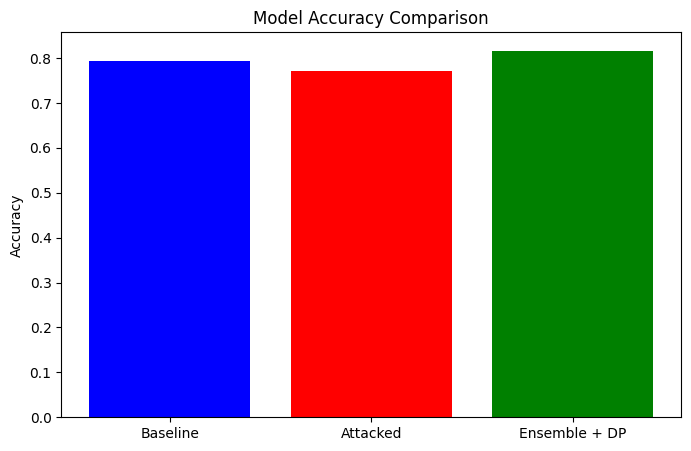

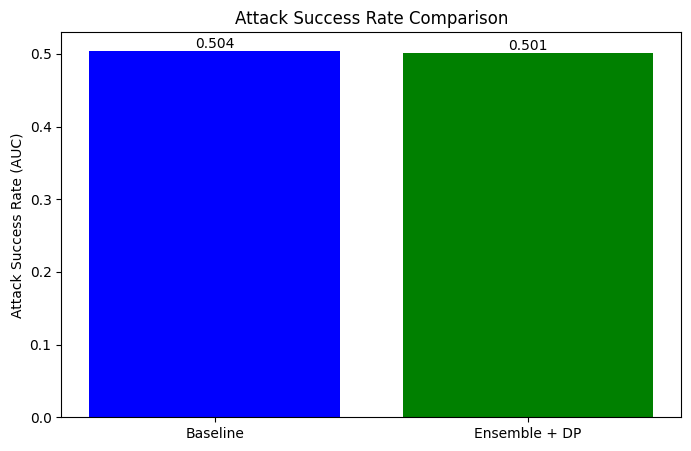

Membership Inference Attack Results with Ensemble + Differential Privacy
                 Model  Accuracy Attack Success Rate (AUC)
0       Baseline Model  0.793667                  0.504405
1       Attacked Model  0.770190                       N/A
2  Ensemble + DP Model  0.816667                  0.501214


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load a complex dataset: UCI Credit Card dataset
credit_data = pd.read_excel("https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls", header=1, index_col=0)
X = credit_data.iloc[:, :-1].values
y = credit_data.iloc[:, -1].values

# Split data for Membership Inference Attack (MIA)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Further split the training set for shadow models
X_train_attack, X_test_attack, y_train_attack, y_test_attack = train_test_split(
    X_train, y_train, test_size=0.5, stratify=y_train, random_state=42
)

# Standardize the dataset
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train_attack = scaler.transform(X_train_attack)
X_test_attack = scaler.transform(X_test_attack)

# Convert data to PyTorch tensors and move to device
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(device)

# Define PyTorch model with adversarial training, dropout, and differential privacy
class AdversarialDPDropoutModel(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim, dropout_prob, noise_scale):
        super(AdversarialDPDropoutModel, self).__init__()
        self.noise_scale = noise_scale
        layers = []
        dims = [input_dim] + hidden_dims
        for i in range(len(dims) - 1):
            layers.append(nn.Linear(dims[i], dims[i + 1]))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_prob))
        layers.append(nn.Linear(dims[-1], output_dim))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        output = self.network(x)
        if self.training:
            noise = torch.normal(0, self.noise_scale, size=output.size(), device=output.device)
            return output + noise
        return output

# Training function for adversarial training
def train_adversarial_model(model, optimizer, criterion, dataloader, num_epochs, epsilon=0.1):
    model.train()
    for epoch in range(num_epochs):
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)

            # Adversarial example generation
            inputs.requires_grad = True
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            optimizer.zero_grad()
            loss.backward(retain_graph=True)  # Retain the computational graph

            with torch.no_grad():
                adv_inputs = inputs + epsilon * inputs.grad.sign()

            inputs.requires_grad = False
            optimizer.zero_grad()

            # Combine adversarial and normal training
            adv_outputs = model(adv_inputs)
            total_loss = criterion(outputs, targets) + criterion(adv_outputs, targets)
            total_loss.backward()
            optimizer.step()

# Define Ensemble Model
class EnsembleModel:
    def __init__(self, models):
        self.models = models

    def predict_proba(self, X):
        # Average predictions from all models
        probs = [torch.softmax(model(X), dim=1).detach().cpu().numpy() for model in self.models]
        return np.mean(probs, axis=0)

# Prepare DataLoader for PyTorch
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Baseline Model Training
baseline_clf = MLPClassifier(hidden_layer_sizes=(64, 32), activation='relu', max_iter=500, random_state=42)
baseline_clf.fit(X_train, y_train)
y_pred_baseline = baseline_clf.predict(X_test)
baseline_acc = accuracy_score(y_test, y_pred_baseline)

# Simulate Attacked Model (Shadow Model Evaluation)
shadow_clf = MLPClassifier(hidden_layer_sizes=(64, 32), activation='relu', max_iter=500, random_state=42)
shadow_clf.fit(X_train_attack, y_train_attack)
y_pred_attacked = shadow_clf.predict(X_test_attack)
attacked_acc = accuracy_score(y_test_attack, y_pred_attacked)

# Attack Model for Baseline
baseline_preds_train = baseline_clf.predict_proba(X_train)[:, 1]
baseline_preds_test = baseline_clf.predict_proba(X_test)[:, 1]
attack_test_X_baseline = np.concatenate([baseline_preds_train, baseline_preds_test])
attack_test_y_baseline = np.concatenate([np.ones_like(baseline_preds_train), np.zeros_like(baseline_preds_test)])
attack_model_baseline = LogisticRegression()
attack_model_baseline.fit(attack_test_X_baseline.reshape(-1, 1), attack_test_y_baseline)
attack_success_baseline = roc_auc_score(attack_test_y_baseline, attack_model_baseline.predict_proba(attack_test_X_baseline.reshape(-1, 1))[:, 1])

# Initialize multiple PyTorch models for ensemble
input_dim = X_train.shape[1]
hidden_dims = [64, 32]
output_dim = 2
dropout_prob = 0.3
noise_scale = 0.1
ensemble_models = []

for _ in range(5):  # Create 5 models
    model = AdversarialDPDropoutModel(input_dim, hidden_dims, output_dim, dropout_prob, noise_scale).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.0005)
    train_adversarial_model(model, optimizer, nn.CrossEntropyLoss(), train_loader, num_epochs=15, epsilon=0.1)
    ensemble_models.append(model)

# Create ensemble model
ensemble_model = EnsembleModel(ensemble_models)

# Evaluate ensemble model
with torch.no_grad():
    test_outputs_ensemble = ensemble_model.predict_proba(X_test_tensor.detach())
    y_pred_ensemble = np.argmax(test_outputs_ensemble, axis=1)
    ensemble_acc = accuracy_score(y_test, y_pred_ensemble)

# Prepare probabilities for attack evaluation
ensemble_preds_train = ensemble_model.predict_proba(X_train_tensor.detach())
ensemble_preds_test = ensemble_model.predict_proba(X_test_tensor.detach())
ensemble_preds_train_prob = ensemble_preds_train[:, 1]
ensemble_preds_test_prob = ensemble_preds_test[:, 1]

# Attack Success Evaluation
attack_test_ensemble_X = np.concatenate([ensemble_preds_train_prob, ensemble_preds_test_prob])
attack_test_ensemble_y = np.concatenate([np.ones_like(ensemble_preds_train_prob), np.zeros_like(ensemble_preds_test_prob)])
attack_success_ensemble = roc_auc_score(attack_test_ensemble_y, attack_model_baseline.predict_proba(attack_test_ensemble_X.reshape(-1, 1))[:, 1])

# Visualization
fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(["Baseline", "Attacked", "Ensemble + DP"],
       [baseline_acc, attacked_acc, ensemble_acc],
       color=['blue', 'red', 'green'])
ax.set_ylabel("Accuracy")
ax.set_title("Model Accuracy Comparison")
plt.show()

# Bar plot for Attack Success Rate
fig, ax = plt.subplots(figsize=(8, 5))
attack_success_rates = [attack_success_baseline, attack_success_ensemble]
labels = ["Baseline", "Ensemble + DP"]
bar_colors = ['blue', 'green']

bars = ax.bar(labels, attack_success_rates, color=bar_colors)
ax.set_ylabel("Attack Success Rate (AUC)")
ax.set_title("Attack Success Rate Comparison")

# Add values on top of bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, f"{height:.3f}", ha='center', va='bottom')

plt.show()

# Display Results
final_results_df = pd.DataFrame({
    "Model": ["Baseline Model", "Attacked Model", "Ensemble + DP Model"],
    "Accuracy": [baseline_acc, attacked_acc, ensemble_acc],
    "Attack Success Rate (AUC)": [attack_success_baseline, "N/A", attack_success_ensemble]
})

print("Membership Inference Attack Results with Ensemble + Differential Privacy")
print(final_results_df)


Using device: cuda


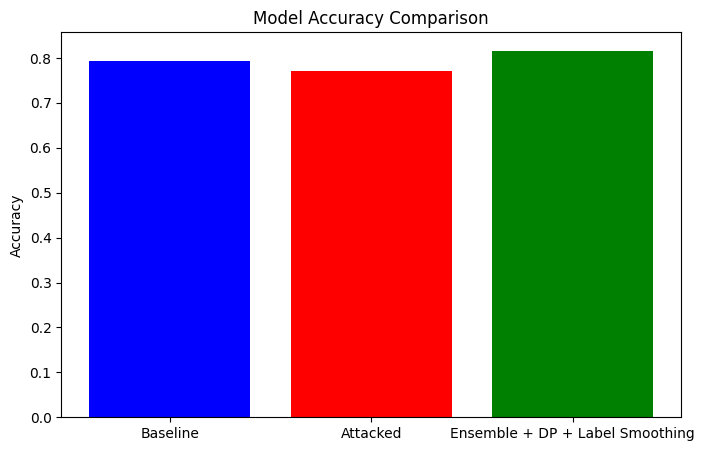

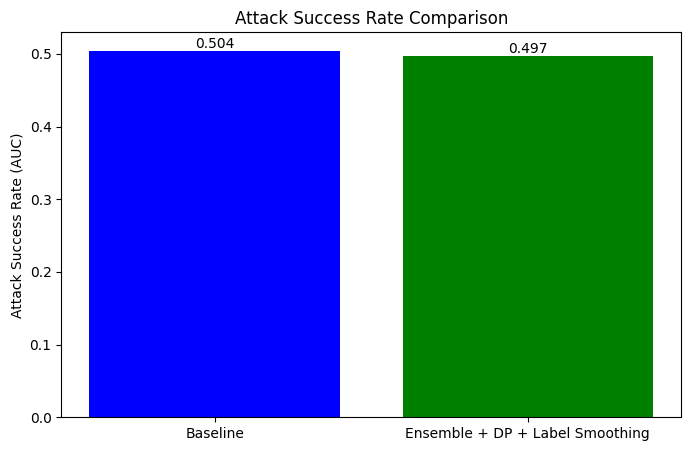

Membership Inference Attack Results with Ensemble + Differential Privacy + Label Smoothing
                             Model  Accuracy Attack Success Rate (AUC)
0                   Baseline Model  0.793667                  0.504405
1                   Attacked Model  0.770190                       N/A
2  Ensemble + DP + Label Smoothing  0.816444                  0.497355


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load a complex dataset: UCI Credit Card dataset
credit_data = pd.read_excel("https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls", header=1, index_col=0)
X = credit_data.iloc[:, :-1].values
y = credit_data.iloc[:, -1].values

# Split data for Membership Inference Attack (MIA)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Further split the training set for shadow models
X_train_attack, X_test_attack, y_train_attack, y_test_attack = train_test_split(
    X_train, y_train, test_size=0.5, stratify=y_train, random_state=42
)

# Standardize the dataset
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train_attack = scaler.transform(X_train_attack)
X_test_attack = scaler.transform(X_test_attack)

# Convert data to PyTorch tensors and move to device
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(device)

# Define PyTorch model with adversarial training, dropout, differential privacy, and label smoothing
class AdversarialDPDropoutModel(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim, dropout_prob, noise_scale):
        super(AdversarialDPDropoutModel, self).__init__()
        self.noise_scale = noise_scale
        layers = []
        dims = [input_dim] + hidden_dims
        for i in range(len(dims) - 1):
            layers.append(nn.Linear(dims[i], dims[i + 1]))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_prob))
        layers.append(nn.Linear(dims[-1], output_dim))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        output = self.network(x)
        if self.training:
            noise = torch.normal(0, self.noise_scale, size=output.size(), device=output.device)
            return output + noise
        return output

# Training function for adversarial training with label smoothing and gradient clipping
def train_adversarial_model(model, optimizer, criterion, dataloader, num_epochs, epsilon=0.1, clip_value=1.0, smoothing=0.1):
    model.train()
    for epoch in range(num_epochs):
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)

            # Apply label smoothing
            targets_one_hot = torch.eye(model.network[-1].out_features, device=device)[targets]
            targets_smoothed = targets_one_hot * (1 - smoothing) + (smoothing / model.network[-1].out_features)

            # Adversarial example generation
            inputs.requires_grad = True
            outputs = model(inputs)
            loss = criterion(outputs, targets_smoothed)
            optimizer.zero_grad()
            loss.backward(retain_graph=True)  # Retain the computational graph

            with torch.no_grad():
                adv_inputs = inputs + epsilon * inputs.grad.sign()

            inputs.requires_grad = False
            optimizer.zero_grad()

            # Combine adversarial and normal training
            adv_outputs = model(adv_inputs)
            total_loss = criterion(outputs, targets_smoothed) + criterion(adv_outputs, targets_smoothed)
            total_loss.backward()

            # Apply gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)
            optimizer.step()

# Define Ensemble Model
class EnsembleModel:
    def __init__(self, models):
        self.models = models

    def predict_proba(self, X):
        # Average predictions from all models
        probs = [torch.softmax(model(X), dim=1).detach().cpu().numpy() for model in self.models]
        return np.mean(probs, axis=0)

# Prepare DataLoader for PyTorch
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Baseline Model Training
baseline_clf = MLPClassifier(hidden_layer_sizes=(64, 32), activation='relu', max_iter=500, random_state=42)
baseline_clf.fit(X_train, y_train)
y_pred_baseline = baseline_clf.predict(X_test)
baseline_acc = accuracy_score(y_test, y_pred_baseline)

# Simulate Attacked Model (Shadow Model Evaluation)
shadow_clf = MLPClassifier(hidden_layer_sizes=(64, 32), activation='relu', max_iter=500, random_state=42)
shadow_clf.fit(X_train_attack, y_train_attack)
y_pred_attacked = shadow_clf.predict(X_test_attack)
attacked_acc = accuracy_score(y_test_attack, y_pred_attacked)

# Attack Model for Baseline
baseline_preds_train = baseline_clf.predict_proba(X_train)[:, 1]
baseline_preds_test = baseline_clf.predict_proba(X_test)[:, 1]
attack_test_X_baseline = np.concatenate([baseline_preds_train, baseline_preds_test])
attack_test_y_baseline = np.concatenate([np.ones_like(baseline_preds_train), np.zeros_like(baseline_preds_test)])
attack_model_baseline = LogisticRegression()
attack_model_baseline.fit(attack_test_X_baseline.reshape(-1, 1), attack_test_y_baseline)
attack_success_baseline = roc_auc_score(attack_test_y_baseline, attack_model_baseline.predict_proba(attack_test_X_baseline.reshape(-1, 1))[:, 1])

# Initialize multiple PyTorch models for ensemble
input_dim = X_train.shape[1]
hidden_dims = [64, 32]
output_dim = 2
dropout_prob = 0.3
noise_scale = 0.1
ensemble_models = []

for _ in range(5):  # Create 5 models
    model = AdversarialDPDropoutModel(input_dim, hidden_dims, output_dim, dropout_prob, noise_scale).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.0005)
    train_adversarial_model(model, optimizer, nn.CrossEntropyLoss(), train_loader, num_epochs=15, epsilon=0.1, clip_value=1.0, smoothing=0.1)
    ensemble_models.append(model)

# Create ensemble model
ensemble_model = EnsembleModel(ensemble_models)

# Evaluate ensemble model
with torch.no_grad():
    test_outputs_ensemble = ensemble_model.predict_proba(X_test_tensor.detach())
    y_pred_ensemble = np.argmax(test_outputs_ensemble, axis=1)
    ensemble_acc = accuracy_score(y_test, y_pred_ensemble)

# Prepare probabilities for attack evaluation
ensemble_preds_train = ensemble_model.predict_proba(X_train_tensor.detach())
ensemble_preds_test = ensemble_model.predict_proba(X_test_tensor.detach())
ensemble_preds_train_prob = ensemble_preds_train[:, 1]
ensemble_preds_test_prob = ensemble_preds_test[:, 1]

# Attack Success Evaluation
attack_test_ensemble_X = np.concatenate([ensemble_preds_train_prob, ensemble_preds_test_prob])
attack_test_ensemble_y = np.concatenate([np.ones_like(ensemble_preds_train_prob), np.zeros_like(ensemble_preds_test_prob)])
attack_success_ensemble = roc_auc_score(attack_test_ensemble_y, attack_model_baseline.predict_proba(attack_test_ensemble_X.reshape(-1, 1))[:, 1])

# Visualization
fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(["Baseline", "Attacked", "Ensemble + DP + Label Smoothing"],
       [baseline_acc, attacked_acc, ensemble_acc],
       color=['blue', 'red', 'green'])
ax.set_ylabel("Accuracy")
ax.set_title("Model Accuracy Comparison")
plt.show()

# Bar plot for Attack Success Rate
fig, ax = plt.subplots(figsize=(8, 5))
attack_success_rates = [attack_success_baseline, attack_success_ensemble]
labels = ["Baseline", "Ensemble + DP + Label Smoothing"]
bar_colors = ['blue', 'green']

bars = ax.bar(labels, attack_success_rates, color=bar_colors)
ax.set_ylabel("Attack Success Rate (AUC)")
ax.set_title("Attack Success Rate Comparison")

# Add values on top of bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, f"{height:.3f}", ha='center', va='bottom')

plt.show()

# Display Results
final_results_df = pd.DataFrame({
    "Model": ["Baseline Model", "Attacked Model", "Ensemble + DP + Label Smoothing"],
    "Accuracy": [baseline_acc, attacked_acc, ensemble_acc],
    "Attack Success Rate (AUC)": [attack_success_baseline, "N/A", attack_success_ensemble]
})

print("Membership Inference Attack Results with Ensemble + Differential Privacy + Label Smoothing")
print(final_results_df)


In [ ]:
pip install blitz-bayesian-pytorch


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.4/48.4 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 70.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 62.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 92.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling

Using device: cuda
Epoch 1/15, Loss: 317.0286
Epoch 2/15, Loss: 292.3483
Epoch 3/15, Loss: 286.9698
Epoch 4/15, Loss: 283.9491
Epoch 5/15, Loss: 282.1767
Epoch 6/15, Loss: 281.1177
Epoch 7/15, Loss: 279.9293
Epoch 8/15, Loss: 279.1793
Epoch 9/15, Loss: 278.5728
Epoch 10/15, Loss: 277.5639
Epoch 11/15, Loss: 277.6622
Epoch 12/15, Loss: 276.3117
Epoch 13/15, Loss: 275.7427
Epoch 14/15, Loss: 275.3568
Epoch 15/15, Loss: 274.8002
Epoch 1/15, Loss: 313.1219
Epoch 2/15, Loss: 291.1225
Epoch 3/15, Loss: 287.2475
Epoch 4/15, Loss: 284.5439
Epoch 5/15, Loss: 282.6645
Epoch 6/15, Loss: 281.3032
Epoch 7/15, Loss: 280.4842
Epoch 8/15, Loss: 279.3659
Epoch 9/15, Loss: 278.6449
Epoch 10/15, Loss: 277.7259
Epoch 11/15, Loss: 277.5058
Epoch 12/15, Loss: 276.2695
Epoch 13/15, Loss: 275.7838
Epoch 14/15, Loss: 275.4103
Epoch 15/15, Loss: 273.9256
Epoch 1/15, Loss: 320.9958
Epoch 2/15, Loss: 292.9387
Epoch 3/15, Loss: 287.4404
Epoch 4/15, Loss: 284.6732
Epoch 5/15, Loss: 282.9964
Epoch 6/15, Loss: 281.01

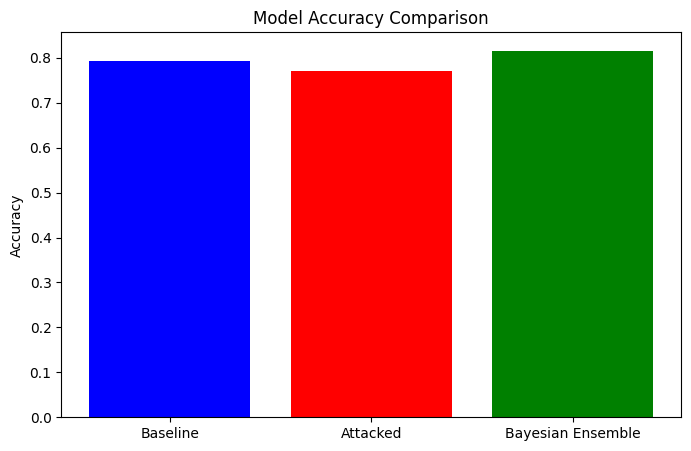

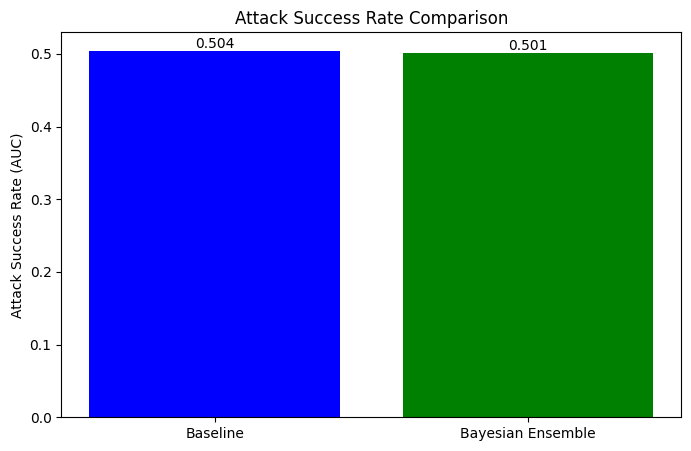

Membership Inference Attack Results with Bayesian Ensemble
               Model  Accuracy Attack Success Rate (AUC)
0     Baseline Model  0.793667                  0.504405
1     Attacked Model  0.770190                       N/A
2  Bayesian Ensemble  0.816000                  0.501496


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from blitz.modules import BayesianLinear
from blitz.utils import variational_estimator

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load a complex dataset: UCI Credit Card dataset
credit_data = pd.read_excel("https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls", header=1, index_col=0)
X = credit_data.iloc[:, :-1].values
y = credit_data.iloc[:, -1].values

# Split data for Membership Inference Attack (MIA)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Further split the training set for shadow models
X_train_attack, X_test_attack, y_train_attack, y_test_attack = train_test_split(
    X_train, y_train, test_size=0.5, stratify=y_train, random_state=42
)

# Standardize the dataset
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train_attack = scaler.transform(X_train_attack)
X_test_attack = scaler.transform(X_test_attack)

# Convert data to PyTorch tensors and move to device
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(device)

# Define Bayesian Neural Network with Variational Inference
@variational_estimator
class BayesianNN(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim):
        super(BayesianNN, self).__init__()
        layers = []
        dims = [input_dim] + hidden_dims
        for i in range(len(dims) - 1):
            layers.append(BayesianLinear(dims[i], dims[i + 1]))
            layers.append(nn.ReLU())
        layers.append(BayesianLinear(dims[-1], output_dim))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

# Training function for Bayesian Neural Network
def train_bayesian_model(model, optimizer, criterion, dataloader, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}")

# Define Ensemble Model with Bayesian Neural Networks
class BayesianEnsembleModel:
    def __init__(self, models):
        self.models = models

    def predict_proba(self, X, n_samples=10):
        # Average predictions from multiple stochastic forward passes
        probs = []
        for model in self.models:
            model_probs = []
            for _ in range(n_samples):
                model_probs.append(torch.softmax(model(X), dim=1).detach().cpu().numpy())
            probs.append(np.mean(model_probs, axis=0))
        return np.mean(probs, axis=0)

# Prepare DataLoader for PyTorch
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Baseline Model Training
baseline_clf = MLPClassifier(hidden_layer_sizes=(64, 32), activation='relu', max_iter=500, random_state=42)
baseline_clf.fit(X_train, y_train)
y_pred_baseline = baseline_clf.predict(X_test)
baseline_acc = accuracy_score(y_test, y_pred_baseline)

# Simulate Attacked Model (Shadow Model Evaluation)
shadow_clf = MLPClassifier(hidden_layer_sizes=(64, 32), activation='relu', max_iter=500, random_state=42)
shadow_clf.fit(X_train_attack, y_train_attack)
y_pred_attacked = shadow_clf.predict(X_test_attack)
attacked_acc = accuracy_score(y_test_attack, y_pred_attacked)

# Attack Model for Baseline
baseline_preds_train = baseline_clf.predict_proba(X_train)[:, 1]
baseline_preds_test = baseline_clf.predict_proba(X_test)[:, 1]
attack_test_X_baseline = np.concatenate([baseline_preds_train, baseline_preds_test])
attack_test_y_baseline = np.concatenate([np.ones_like(baseline_preds_train), np.zeros_like(baseline_preds_test)])
attack_model_baseline = LogisticRegression()
attack_model_baseline.fit(attack_test_X_baseline.reshape(-1, 1), attack_test_y_baseline)
attack_success_baseline = roc_auc_score(attack_test_y_baseline, attack_model_baseline.predict_proba(attack_test_X_baseline.reshape(-1, 1))[:, 1])

# Initialize multiple Bayesian Neural Networks for ensemble
input_dim = X_train.shape[1]
hidden_dims = [64, 32]
output_dim = 2
bayesian_ensemble_models = []

for _ in range(5):  # Create 5 Bayesian models
    model = BayesianNN(input_dim, hidden_dims, output_dim).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.0005)
    train_bayesian_model(model, optimizer, nn.CrossEntropyLoss(), train_loader, num_epochs=15)
    bayesian_ensemble_models.append(model)

# Create ensemble model
bayesian_ensemble_model = BayesianEnsembleModel(bayesian_ensemble_models)

# Evaluate Bayesian ensemble model
with torch.no_grad():
    test_outputs_ensemble = bayesian_ensemble_model.predict_proba(X_test_tensor.detach())
    y_pred_ensemble = np.argmax(test_outputs_ensemble, axis=1)
    ensemble_acc = accuracy_score(y_test, y_pred_ensemble)

# Prepare probabilities for attack evaluation
ensemble_preds_train = bayesian_ensemble_model.predict_proba(X_train_tensor.detach())
ensemble_preds_test = bayesian_ensemble_model.predict_proba(X_test_tensor.detach())
ensemble_preds_train_prob = ensemble_preds_train[:, 1]
ensemble_preds_test_prob = ensemble_preds_test[:, 1]

# Attack Success Evaluation
attack_test_ensemble_X = np.concatenate([ensemble_preds_train_prob, ensemble_preds_test_prob])
attack_test_ensemble_y = np.concatenate([np.ones_like(ensemble_preds_train_prob), np.zeros_like(ensemble_preds_test_prob)])
attack_success_ensemble = roc_auc_score(attack_test_ensemble_y, attack_model_baseline.predict_proba(attack_test_ensemble_X.reshape(-1, 1))[:, 1])

# Visualization
fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(["Baseline", "Attacked", "Bayesian Ensemble"],
       [baseline_acc, attacked_acc, ensemble_acc],
       color=['blue', 'red', 'green'])
ax.set_ylabel("Accuracy")
ax.set_title("Model Accuracy Comparison")
plt.show()

# Bar plot for Attack Success Rate
fig, ax = plt.subplots(figsize=(8, 5))
attack_success_rates = [attack_success_baseline, attack_success_ensemble]
labels = ["Baseline", "Bayesian Ensemble"]
bar_colors = ['blue', 'green']

bars = ax.bar(labels, attack_success_rates, color=bar_colors)
ax.set_ylabel("Attack Success Rate (AUC)")
ax.set_title("Attack Success Rate Comparison")

# Add values on top of bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, f"{height:.3f}", ha='center', va='bottom')

plt.show()

# Display Results
final_results_df = pd.DataFrame({
    "Model": ["Baseline Model", "Attacked Model", "Bayesian Ensemble"],
    "Accuracy": [baseline_acc, attacked_acc, ensemble_acc],
    "Attack Success Rate (AUC)": [attack_success_baseline, "N/A", attack_success_ensemble]
})

print("Membership Inference Attack Results with Bayesian Ensemble")
print(final_results_df)
